# Exploratory Data Analysis for Golf Swing data collected by simulators & perfomed by golfer


# Wish i can find out golf ball trajectory based on swing measurements?

Any golfer with any skill level starting from beginner to pro, they are always curious about how to controll swring parameters to shape ball trajectory. Golfer always struggles swing after swing to control the factors affecting shape of ball trajectory. As a outdoor sports, golfer wants to create different shape of trajectory to cope up with wind, rain, hold position, avoiding hazzards. For this probelm golfer want to understand what all swing measurements drive ball trajectory. This dataset has no golfer demographic and skill level information. 
First we need to explore the data and see what all information is available to us.


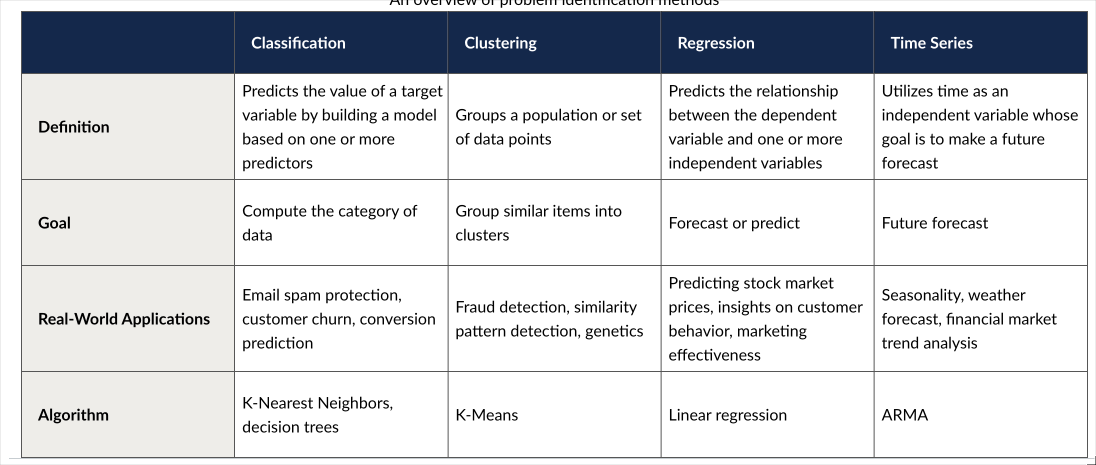

## Standard package imports

In [138]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn . neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from time import process_time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Common Utility Functions



In [144]:
def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    

def plot_hist(df, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


def plot_ts(series, figsize=(20, 6), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_barh(df, feature_name, normalize=True, 
              kind='barh', figsize=(15,5), sort_index=False, title=None):
    """
    Plot barh for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    else:   
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    
    plt.legend()
    plt.show()


def plot_barv(df,xi,yi,ititle):
    fig = px.bar(df, x=xi, y=yi,title=ititle)
    fig.show()

def plot_line(df,xi,yi,ititle):
    fig = px.line(df, x=xi, y=yi,title=ititle)
    fig.show()

def plot_boxh(df, feature_name, kind='box', log=True):
    """
    Box plot
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='box', vert=False, 
                                                  figsize=(10, 6), 
                                                  title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='box', vert=False, 
                              figsize=(10, 6), 
                              title=f'Distribution of {feature_name}')
    plt.show()
    

def plot_scatter(df, feature_x, feature_y, figsize=(10,10), 
                 title=None, xlabel=None, ylabel=None):
    """
    Plot satter     
    """
    df.plot.scatter(feature_x, feature_y, 
                    figsize=(8, 6), title=title, 
                    legend=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_pca(df,features,target):
    pca = PCA()
    components = pca.fit_transform(df[features])
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
    print(pca.components_)
    fig = px.scatter_matrix(
        components,
        labels=labels,
        dimensions=range(2),
        color=df[target]
    )
    fig.update_traces(diagonal_visible=False)
    fig.show()
    return pca

def plot_pca_loading(PCA,df,target):
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    print(loadings)
    fig = px.scatter(components, x=0, y=1, color=df[target])

    for i, feature in enumerate(features):
        fig.add_annotation(
            ax=0, ay=0,
            axref="x", ayref="y",
            x=loadings[i, 0],
            y=loadings[i, 1],
            showarrow=True,
            arrowsize=2,
            arrowhead=2,
            xanchor="right",
            yanchor="top"
        )
        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature,
            yshift=5,
        )
    fig.show()

def plot_biplot(df):
    scaler = StandardScaler()
    scaler.fit(df) 
    df_scaled = scaler.transform(df)
    pca = PCA(n_components=2)

    PC_scores = pd.DataFrame(pca.fit_transform(df_scaled),
                columns = ['PC 1', 'PC 2'])
    PC_scores.head(48)

    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], 
                            index=df.columns)
    print(loadings)
    PC1 = pca.fit_transform(df_scaled)[:,0]
    PC2 = pca.fit_transform(df_scaled)[:,1]
    ldngs = pca.components_

    scalePC1 = 1.0/(PC1.max() - PC1.min())
    scalePC2 = 1.0/(PC2.max() - PC2.min())
    features = df.columns

    fig, ax = plt.subplots(figsize=(14, 9))
    
    for i, feature in enumerate(features):
        ax.arrow(0, 0, ldngs[0, i], 
                ldngs[1, i])
        ax.text(ldngs[0, i] * 1.15, 
                ldngs[1, i] * 1.15, 
                feature, fontsize=18)
    
    ax.scatter(PC1 * scalePC1,PC2 * scalePC2)
    
    ax.set_xlabel('PC1', fontsize=20)
    ax.set_ylabel('PC2', fontsize=20)
    ax.set_title('Figure 1', fontsize=20)


def calc_knn_acc(xtrain,ytrain,xtest,ytest,n):
    knn_classifier = KNeighborsClassifier (n_neighbors =n)
    start= process_time()
    knn_classifier.fit ( xtrain,np.ravel(ytrain ))
    end = process_time()
    knn_pred = knn_classifier.predict (xtest )
    print("Classification report for {}:\n{}".format(knn_classifier, classification_report(ytest, knn_pred)))
    return knn_classifier, round(accuracy_score(ytest,knn_pred)*100,2), end-start

def calc_SVM_acc(xtrain,ytrain,xtest,ytest):
    svm_clf = svm.SVC(kernel='linear')
    start = process_time()
    svm_clf.fit (xtrain,np.ravel(ytrain))
    end=process_time()
    svm_pred = svm_clf.predict(xtest)
    print("Classification report for {}:\n{}".format(svm_clf, classification_report(ytest, svm_pred)))
    return svm_clf,round(accuracy_score(ytest,svm_pred)*100,2) , end-start

def calc_decision_acc(xtrain,ytrain,xtest,ytest):
    dt_clf= DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    start = process_time()
    dt_clf.fit(xtrain, ytrain)
    end=process_time()
    dt_pred = dt_clf.predict(xtest)
    print("Classification report for {}:\n{}".format(dt_clf, classification_report(ytest, dt_pred)))
    return dt_clf,round(accuracy_score(ytest,dt_pred)*100,2) , end-start

# Data Description

Using golf simulator i have collected 850 swings which includes 24 swing measurements.  This dataset contains both categorical and non-categorical attributes. Here are the list of swing measurements.
								
1) Carry Distance - The carry of a golf shot is how far the ball travels before it hits the ground for the first time.
2) Total Distance - Total distance = carry distance + distance ball rolls after hiting the ground
3) Side Distance - Side is the distance from the target line based on where the ball lands.
4) Smash Factor - Smash Factor relates to the amount of energy transferred from the club head to the golf ball. The higher the smash factor the better the energy transfer.
5) Club Speed - Speed of club in mph
6) Side Spin -  Ball side spin - left or right spin measured in degree at which ball spins
7) Back Spin -  back spin rate of ball
8) Ball Speed - Ball speed is a measure of how fast your ball leaves the club head after impact.
9) Lie angle - Lie angle is the angle created between the center of the shaft and ground when you put your iron down in the address position.
10) Attack Angle - The up or down movement of the club head at the time of maximum compression. Attack angle is measured relative to the horizon.
11) Launch Angle - Launch Angle is the angle the ball takes off at relative to the horizon. Launch angle is highly correlated to dynamic loft.
12) Side Angle - Side Angle Determines if You Will Hit a Power Fade or a Slice.
13) Decent Angle - A ball rolling along the ground has a landing angle of zero, whereas a golf ball dropping from the heavens has a descent angle of 90 degrees
14) Apex - maximum height ball attains
15) Flight Time - time in the air
16) Swing Type - fade, draw, straight etc
17) Sping Axis - Spin axis represents the amount of curvature of a golf shot. A negative spin axis represents a ball curving to the left, a positive spin axis represents a right
18) Face Angle - Face Angle is the direction the club face is pointed (right or left) at impact 
19) Club Path
20) Club Lie - club angle when resting on the ground
21) Impact POS - NA
22) Dynamic Loft - NA
23) Face to path - face open or close relative to pathof the swing.

In real-life above all factors can affect the overall price of used car. I think Geographic, ownership/vin and Manufacture/Model information will all too much categorical and can increase the complexity of model by adding unnessary dimensionality.
For this study, i want to focus on core features of the car which directly incluences the price of the car. Next step is to prepare the dataset around using "core feartures of the used car".  lets see how the fidelity of data maintains. If it drops the records drastically, we need to comeup with different approch.



In [5]:
# Read the data and prepare the dataframe containing core features of the used car
DATA_DIR = "./data"

orig_golf_swing_df = pd.read_csv(f"{DATA_DIR}/Golf Swing Data Master1.csv")



#print("total golf swings = ",orig_golf_swing_df.describe)
#print("No of swing type=",orig_golf_swing_df.value_counts('Type').shape)

orig_golf_swing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Carry               876 non-null    float64
 1   Total               876 non-null    float64
 2   Side Dist           876 non-null    object 
 3   Smash Factor        876 non-null    float64
 4   Club Speed          876 non-null    float64
 5   Ball Speed          876 non-null    float64
 6   Back Spin           874 non-null    float64
 7   Side Spin Angle     874 non-null    object 
 8   Side Spin           874 non-null    object 
 9   Launch Angle        876 non-null    float64
 10  Side Angle          876 non-null    object 
 11  Decent Angle        876 non-null    float64
 12  Apex                876 non-null    float64
 13  Flight Time         876 non-null    object 
 14  Type                874 non-null    object 
 15  Spin Axis           874 non-null    float64
 16  Face Ang

# Data Cleanup

1.   Drop unnessary columns

In [6]:
orig_golf_swing_df= orig_golf_swing_df.drop(columns=['Attack Angle','Club Lie','Impact Pos X','Impact Pos Y','Dynamic Loft','Apex','Flight Time'])
orig_golf_swing_df=orig_golf_swing_df.dropna()
orig_golf_swing_df

,Carry,Total,Side Dist,Smash Factor,Club Speed,Ball Speed,Back Spin,Side Spin Angle,Side Spin,Launch Angle,Side Angle,Decent Angle,Type,Spin Axis,Face Angle,Face Path Angle,Club Path,Club Path Angle,Face to Path Angle,Face to Path
0,19.2,23.4,L 1.7,1.34,24.4,32.6,1863.0,L 715,L 715,28.6,L 3.1,30.3,Hook,-21.0,L 5.2,L 5.2,R 15.0,R 15.0,L 20.2,L 20.2
2,72.4,82.2,L 5.0,1.36,50.8,69.2,2572.0,L 63,L 63,18.5,L 3.3,25.4,Straight,-1.4,L 3.5,L 3.5,L 1.3,L 1.3,L 2.2,L 2.2
3,81.1,89.3,L 2.9,1.32,55.8,73.7,3967.0,R 411,R 411,18.1,L 3.4,27.7,Fade,5.9,L 3.3,L 3.3,L 4.3,L 4.3,R 1.1,R 1.1
4,8.1,18.4,R 0.2,1.25,56.0,70.2,1212.0,R 1252,R 1252,1.5,L 0.4,1.6,Slice,45.9,L 0.4,L 0.4,R 0.1,R 0.1,L 0.6,L 0.6
5,38.9,45.8,R 11.6,1.07,54.8,58.7,3245.0,R 3589,R 3589,13.7,R 9.1,16.8,Push Slice,47.9,R 10.5,R 10.5,L 3.2,L 3.2,R 13.7,R 13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,78.4,77.5,R 7.9,1.00,70.3,70.0,10485.0,R 481,R 481,31.0,R 5.0,47.5,Straight,2.6,R 4.7,R 4.7,R 8.1,R 8.1,L 3.4,L 3.4
872,82.8,86.8,R 6.5,1.06,67.3,71.1,6887.0,R 195,R 195,32.0,R 3.9,47.0,Straight,1.6,R 3.7,R 3.7,R 5.4,R 5.4,L 1.7,L 1.7
873,73.4,74.3,R 1.8,0.96,69.1,66.5,9114.0,L 396,L 396,29.0,R 2.1,43.2,Straight,-2.5,R 1.8,R 1.8,R 4.6,R 4.6,L 2.8,L 2.8
874,97.4,101.2,L 6.4,1.42,56.9,80.9,7906.0,L 883,L 883,21.0,L 1.4,38.0,Draw,-6.4,L 1.6,L 1.6,R 0.0,R 0.0,L 1.6,L 1.6


2.  Parse the column values to separate direction and distance

In [7]:
##  Fixing side angle column

orig_golf_swing_df['Side Spin Angle'] = orig_golf_swing_df['Side Spin'].astype(str).str[:1].replace('',0)
orig_golf_swing_df['Side Spin'] = orig_golf_swing_df['Side Spin'].astype(str).str[2:].replace('',0).replace('',0)

#  Fixing Face angle column

orig_golf_swing_df['Face Angle'] = orig_golf_swing_df['Face Path Angle'].astype(str).str[:1].replace('',0)
orig_golf_swing_df['Face Path Angle'] = orig_golf_swing_df['Face Path Angle'].astype(str).str[2:].replace('',0)

#  Fixing Club Path
orig_golf_swing_df['Club Path Angle'] = orig_golf_swing_df['Club Path'].astype(str).str[:1].replace('',0)
orig_golf_swing_df['Club Path'] = orig_golf_swing_df['Club Path'].astype(str).str[2:].replace('',0)

# Fixing Face to Path angle

orig_golf_swing_df['Face to Path Angle'] = orig_golf_swing_df['Face to Path'].astype(str).str[:1].replace('',0)
orig_golf_swing_df['Face to Path'] = orig_golf_swing_df['Face to Path'].astype(str).str[2:].replace('',0)

orig_golf_swing_df['Side Dist Angle'] = orig_golf_swing_df['Side Dist'].astype(str).str[:1].replace('',0)
orig_golf_swing_df['Side Dist'] = orig_golf_swing_df['Side Dist'].astype(str).str[2:].replace('',0)



# fixing side angle
orig_golf_swing_df['Side Angle Dir'] = orig_golf_swing_df['Side Angle'].astype(str).str[:1].replace('',0)
orig_golf_swing_df['Side Angle'] = orig_golf_swing_df['Side Angle'].astype(str).str[2:].replace('',0)



In [8]:
clean_golf_swing_df= orig_golf_swing_df

clean_golf_swing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 799 entries, 0 to 875
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Carry               799 non-null    float64
 1   Total               799 non-null    float64
 2   Side Dist           799 non-null    object 
 3   Smash Factor        799 non-null    float64
 4   Club Speed          799 non-null    float64
 5   Ball Speed          799 non-null    float64
 6   Back Spin           799 non-null    float64
 7   Side Spin Angle     799 non-null    object 
 8   Side Spin           799 non-null    object 
 9   Launch Angle        799 non-null    float64
 10  Side Angle          799 non-null    object 
 11  Decent Angle        799 non-null    float64
 12  Type                799 non-null    object 
 13  Spin Axis           799 non-null    float64
 14  Face Angle          799 non-null    object 
 15  Face Path Angle     799 non-null    object 
 16  Club Path    

In [9]:
clean_golf_swing_df.head(30)
#clean_golf_swing_df.to_csv('clean.csv')


,Carry,Total,Side Dist,Smash Factor,Club Speed,Ball Speed,Back Spin,Side Spin Angle,Side Spin,Launch Angle,...,Type,Spin Axis,Face Angle,Face Path Angle,Club Path,Club Path Angle,Face to Path Angle,Face to Path,Side Dist Angle,Side Angle Dir
0,19.2,23.4,1.7,1.34,24.4,32.6,1863.0,L,715,28.6,...,Hook,-21.0,L,5.2,15.0,R,L,20.2,L,L
2,72.4,82.2,5.0,1.36,50.8,69.2,2572.0,L,63,18.5,...,Straight,-1.4,L,3.5,1.3,L,L,2.2,L,L
3,81.1,89.3,2.9,1.32,55.8,73.7,3967.0,R,411,18.1,...,Fade,5.9,L,3.3,4.3,L,R,1.1,L,L
4,8.1,18.4,0.2,1.25,56.0,70.2,1212.0,R,1252,1.5,...,Slice,45.9,L,0.4,0.1,R,L,0.6,R,L
5,38.9,45.8,11.6,1.07,54.8,58.7,3245.0,R,3589,13.7,...,Push Slice,47.9,R,10.5,3.2,L,R,13.7,R,R
6,52.4,59.4,17.1,1.08,56.7,61.1,3637.0,R,3497,19.1,...,Push Slice,43.9,R,10.9,0.7,L,R,11.6,R,R
7,54.7,63.4,3.4,1.18,55.9,66.0,2597.0,R,1087,14.1,...,Slice,22.7,L,6.8,3.0,L,L,3.8,L,L
8,79.8,90.5,0.8,1.38,51.7,71.3,2161.0,L,62,20.1,...,Straight,-1.7,R,1.2,2.3,L,R,3.5,R,R
9,0.7,4.8,1.0,1.30,59.2,76.8,-2.0,L,6,-0.2,...,Pull Hook,-66.7,L,12.4,3.5,L,L,8.9,L,L
12,73.3,81.6,1.0,1.33,51.3,68.1,3597.0,R,49,20.7,...,Straight,0.8,R,1.2,5.2,L,R,6.5,R,R


3.  Remove record having less than 70 yrds total distance that can be resulted becaus of miss hit

In [10]:

clean_golf_swing_df = clean_golf_swing_df.where(clean_golf_swing_df['Carry'] >= 40.0)

clean_golf_swing_df = clean_golf_swing_df.dropna()

clean_golf_swing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 725 entries, 2 to 875
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Carry               725 non-null    float64
 1   Total               725 non-null    float64
 2   Side Dist           725 non-null    object 
 3   Smash Factor        725 non-null    float64
 4   Club Speed          725 non-null    float64
 5   Ball Speed          725 non-null    float64
 6   Back Spin           725 non-null    float64
 7   Side Spin Angle     725 non-null    object 
 8   Side Spin           725 non-null    object 
 9   Launch Angle        725 non-null    float64
 10  Side Angle          725 non-null    object 
 11  Decent Angle        725 non-null    float64
 12  Type                725 non-null    object 
 13  Spin Axis           725 non-null    float64
 14  Face Angle          725 non-null    object 
 15  Face Path Angle     725 non-null    object 
 16  Club Path    

4.  Convert columns datatype

In [11]:

clean_golf_swing_df= clean_golf_swing_df.astype({'Side Spin': 'float64','Side Dist': 'float64','Face to Path': 'float64','Face Path Angle': 'float64','Club Path':'float64'})

clean_golf_swing_df.head()

#orig_golf_swing_df

,Carry,Total,Side Dist,Smash Factor,Club Speed,Ball Speed,Back Spin,Side Spin Angle,Side Spin,Launch Angle,...,Type,Spin Axis,Face Angle,Face Path Angle,Club Path,Club Path Angle,Face to Path Angle,Face to Path,Side Dist Angle,Side Angle Dir
2,72.4,82.2,5.0,1.36,50.8,69.2,2572.0,L,63.0,18.5,...,Straight,-1.4,L,3.5,1.3,L,L,2.2,L,L
3,81.1,89.3,2.9,1.32,55.8,73.7,3967.0,R,411.0,18.1,...,Fade,5.9,L,3.3,4.3,L,R,1.1,L,L
6,52.4,59.4,17.1,1.08,56.7,61.1,3637.0,R,3497.0,19.1,...,Push Slice,43.9,R,10.9,0.7,L,R,11.6,R,R
7,54.7,63.4,3.4,1.18,55.9,66.0,2597.0,R,1087.0,14.1,...,Slice,22.7,L,6.8,3.0,L,L,3.8,L,L
8,79.8,90.5,0.8,1.38,51.7,71.3,2161.0,L,62.0,20.1,...,Straight,-1.7,R,1.2,2.3,L,R,3.5,R,R


5.   Convert categorical columns using simple strategy which is assign 1 for L(Left) and 2 for R(Right).

In [12]:
clean_golf_swing_df= clean_golf_swing_df.replace('L',1).replace('R',2)
clean_golf_swing_df.head()


,Carry,Total,Side Dist,Smash Factor,Club Speed,Ball Speed,Back Spin,Side Spin Angle,Side Spin,Launch Angle,...,Type,Spin Axis,Face Angle,Face Path Angle,Club Path,Club Path Angle,Face to Path Angle,Face to Path,Side Dist Angle,Side Angle Dir
2,72.4,82.2,5.0,1.36,50.8,69.2,2572.0,1,63.0,18.5,...,Straight,-1.4,1,3.5,1.3,1,1,2.2,1,1
3,81.1,89.3,2.9,1.32,55.8,73.7,3967.0,2,411.0,18.1,...,Fade,5.9,1,3.3,4.3,1,2,1.1,1,1
6,52.4,59.4,17.1,1.08,56.7,61.1,3637.0,2,3497.0,19.1,...,Push Slice,43.9,2,10.9,0.7,1,2,11.6,2,2
7,54.7,63.4,3.4,1.18,55.9,66.0,2597.0,2,1087.0,14.1,...,Slice,22.7,1,6.8,3.0,1,1,3.8,1,1
8,79.8,90.5,0.8,1.38,51.7,71.3,2161.0,1,62.0,20.1,...,Straight,-1.7,2,1.2,2.3,1,2,3.5,2,2



# Data breakdown

  -  End of all data cleanups , we have total 820 swings data

   

# Results of duplicates

Since, this entire dataset captured by actual swing perfomed by actual golfer. There is chance of having duplicates in this dataset.

# Data Exploration

### No of swing by ball trajectory
    -  This golfer has majority of swing types in straight, draw, fade and hook and slice. occessionally, golfer has pull hook and push hook swing type. 
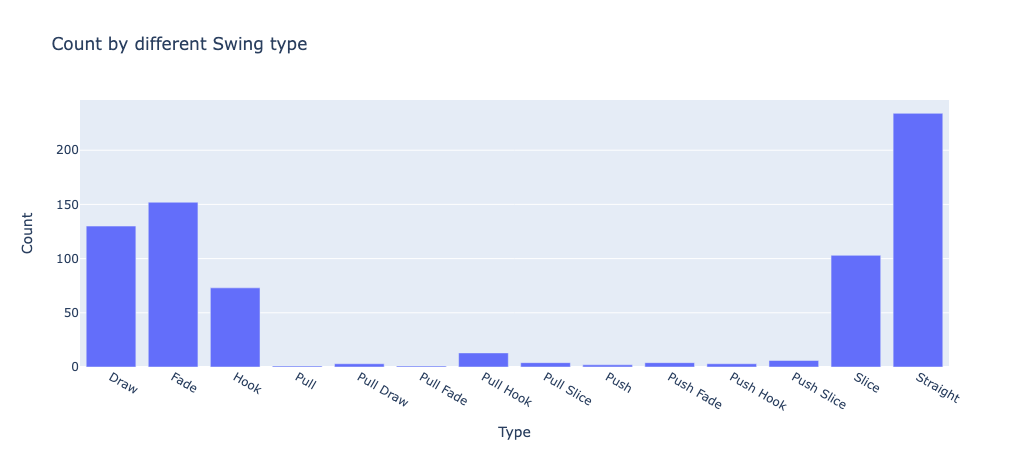

In [13]:
#  no by swing type

swing_by_shape= clean_golf_swing_df.groupby('Type')['Total'].count().to_frame('Count').reset_index()
swing_by_shape
plot_barv(swing_by_shape,'Type','Count','Count by different Swing type')

### Carry distance vs smash factor
-  This graph shows as smash factor increases which results in overall carry distance. So, for golfer having right smash factor is very important. Smash factor of 1.3 and above is very important to achieve good carry distance.


![Carry vs smash.png](<attachment:Carry vs smash.png>)
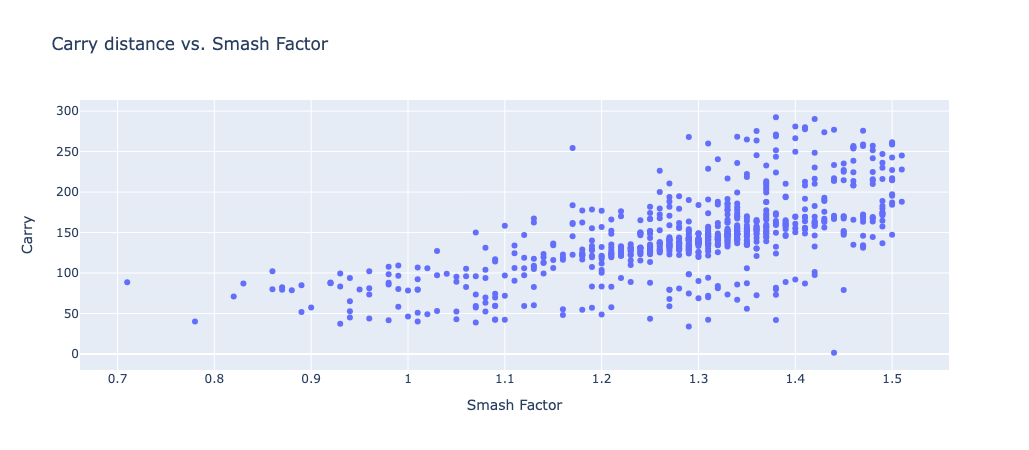

In [14]:
# calculate age of the used car
#vehicles_clean['age']= 2023 - vehicles_clean.year
#print('Oldest Used Car ', vehicles_clean['age'].max())
#print('Newest Used Car ', vehicles_clean['age'].min())
#print('Highest Used Car Price ', vehicles_clean['price'].max())
#print('Lowest Used Car Price ', vehicles_clean['price'].min())
#plot_line(vehicles_clean,'age','price','Used Car Age vs Price')

fig = px.scatter(clean_golf_swing_df,y='Carry', x='Smash Factor',title="Carry distance vs. Smash Factor")
fig.show()



###  Carry Distance vs Ball speed

As you can see Carry distance and ball speed are positively correlated. 

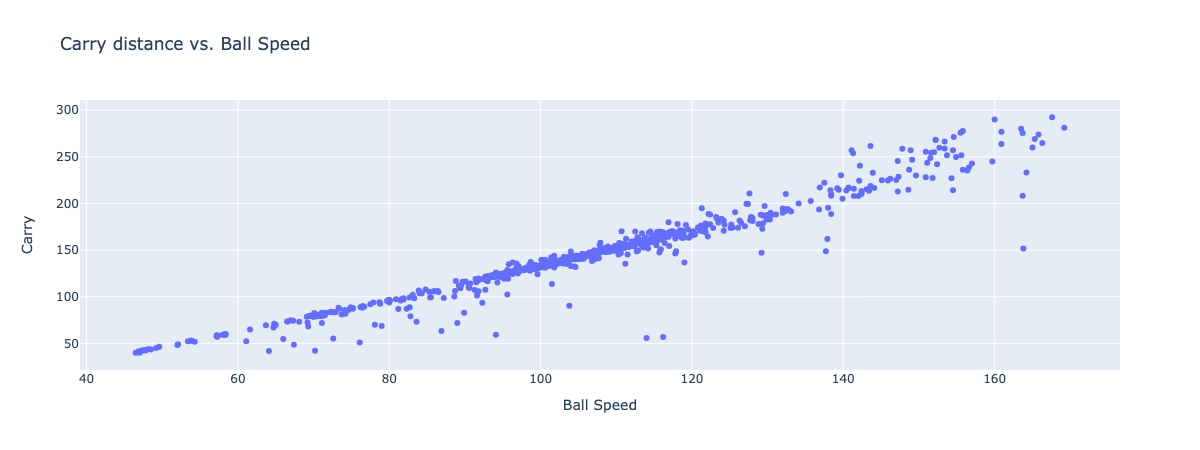

In [52]:
fig = px.scatter(clean_golf_swing_df,y='Carry', x='Ball Speed',title="Carry distance vs. Ball Speed")
fig.show()

###  Carry distance vs launch angle

As launch angle decreases carry distance increases. 

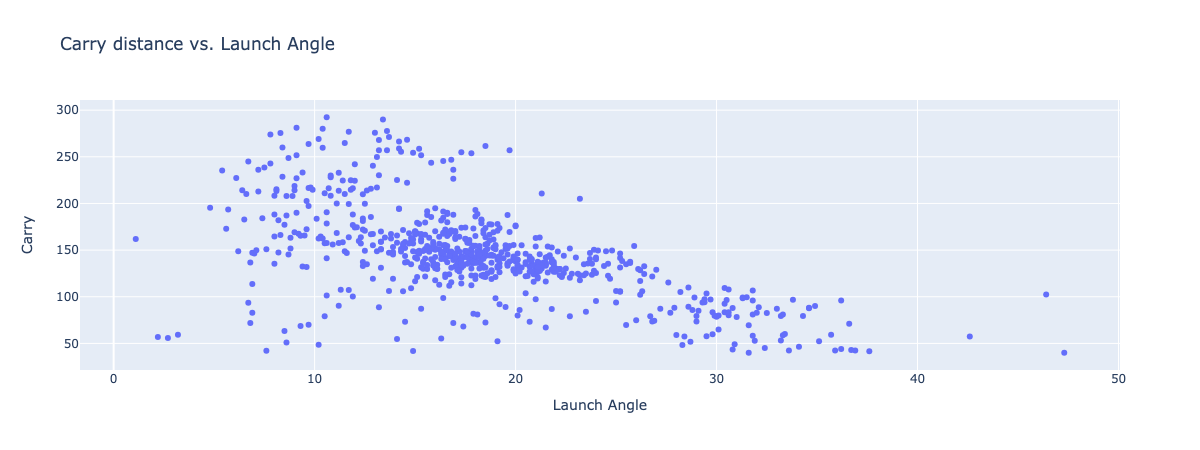

In [53]:
fig = px.scatter(clean_golf_swing_df,y='Carry', x='Launch Angle',title="Carry distance vs. Launch Angle")
fig.show()

# Correlation Matrix



- Step 1.  Encode target column "Type"

    -    Straight      0
    -    Fade          1
     -    Draw          2
     -    Slice         3
     -    Hook          4
     -    Pull Hook     5
     -    Push Slice    6
     -    Pull Slice    7
     -    Push Fade     8
     -    Pull Draw     9
     -    Push Hook     10
     -    Push          11
     -    Pull Fade     12
     -    Pull          13

In [15]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
clean_golf_swing_df['Type'] = labelencoder.fit_transform(clean_golf_swing_df['Type'])

In [16]:

clean_golf_swing_df.corr()

,Carry,Total,Side Dist,Smash Factor,Club Speed,Ball Speed,Back Spin,Side Spin Angle,Side Spin,Launch Angle,...,Type,Spin Axis,Face Angle,Face Path Angle,Club Path,Club Path Angle,Face to Path Angle,Face to Path,Side Dist Angle,Side Angle Dir
Carry,1.000000,0.997975,0.484094,0.659348,0.852952,0.967071,-0.409840,-0.064047,-0.088294,-0.598140,...,0.014171,-0.027056,0.023455,-0.000114,-0.027928,-0.185585,0.090443,-0.175695,0.040471,0.022878
Total,0.997975,1.000000,0.502367,0.668688,0.850169,0.969252,-0.464193,-0.071219,-0.075615,-0.618525,...,0.010726,-0.036620,0.025274,0.017823,-0.022647,-0.190482,0.092156,-0.161128,0.034908,0.023144
Side Dist,0.484094,0.502367,1.000000,0.293667,0.461724,0.498578,-0.465569,-0.045560,0.495520,-0.286437,...,-0.019224,0.013451,0.064114,0.419506,0.032410,-0.205279,0.135746,0.231842,0.063442,0.065371
Smash Factor,0.659348,0.668688,0.293667,1.000000,0.283978,0.687281,-0.422806,-0.167560,-0.024453,-0.622566,...,-0.007610,-0.100781,0.066115,-0.045448,-0.185298,0.049847,-0.090835,-0.181788,-0.004690,0.092852
Club Speed,0.852952,0.850169,0.461724,0.283978,1.000000,0.885876,-0.310195,0.014075,0.000295,-0.556932,...,0.034672,0.022860,-0.031242,0.066218,0.020183,-0.276904,0.152775,-0.091707,0.056621,-0.038653
Ball Speed,0.967071,0.969252,0.498578,0.687281,0.885876,1.000000,-0.440651,-0.062405,-0.018554,-0.702241,...,0.023937,-0.037529,0.005470,0.027925,-0.059055,-0.195610,0.073932,-0.155995,0.037822,0.010688
Back Spin,-0.409840,-0.464193,-0.465569,-0.422806,-0.310195,-0.440651,1.000000,0.135694,-0.146359,0.566756,...,0.058816,0.091689,-0.005018,-0.260351,-0.042966,0.193724,-0.075617,-0.141284,0.076895,0.021092
Side Spin Angle,-0.064047,-0.071219,-0.045560,-0.167560,0.014075,-0.062405,0.135694,1.000000,0.119259,0.127017,...,0.236595,0.612932,0.160154,-0.031319,-0.008907,-0.254063,0.456053,-0.106136,0.635202,0.111289
Side Spin,-0.088294,-0.075615,0.495520,-0.024453,0.000295,-0.018554,-0.146359,0.119259,1.000000,-0.006428,...,-0.132307,0.215874,0.091373,0.267330,0.043857,-0.170891,0.256141,0.321318,0.193929,0.096170
Launch Angle,-0.598140,-0.618525,-0.286437,-0.622566,-0.556932,-0.702241,0.566756,0.127017,-0.006428,1.000000,...,-0.001982,0.038095,0.040408,-0.065283,0.125168,0.025044,0.082611,0.108374,0.037564,0.019540


-  Step 2:  Lets categorized attributes to develop more insight into correlation matrix

| Index | Column            |  Non-Null Count  |Dtype       |   Factors incluencing targets                                           |
|-------|  ------           |   -------------- | -----      |    -------------------------------                    |
| 0     |Carry              |  725 non-null    |float64     |    Target Attribute                                      |
| 1   |Total               |725 non-null    |float64| NA | 
|2  | Side Dist           |725 non-null   | float64| Target Attribute to find out distance away from target line|
| 3  | Smash Factor       | 725 non-null  |  float64| Carry |
| 4  | Club Speed         | 725 non-null  |  float64| Carry |
| 5  | Ball Speed         | 725 non-null  |  float64| Carry |
| 6  | Back Spin           |725 non-null   | float64| Carry |
| 7  | Side Spin Angle     |725 non-null   | int64  | Type|
| 8  | Side Spin           |725 non-null   | float64| Type |
| 9  | Launch Angle        |725 non-null   | float64| Carry|
| 10 | Side Angle          |725 non-null   | object | Type|
| 11 | Decent Angle        |725 non-null   | float64| Type|
| 12  |Type                |725 non-null   | int64  | Target to predict shape of the ball flight |
| 13 | Spin Axis           |725 non-null   | float64| Carry |
| 14 | Face Angle         | 725 non-null   | int64  | Type|
| 15 | Face Path Angle    |725 non-null   | float64| Type|
| 16  |Club Path           |725 non-null   | float64| Type|
| 17  |Club Path Angle    | 725 non-null   | int64  | Type|
| 18 | Face to Path Angle  |725 non-null   | int64  | Type|
| 19  |Face to Path       | 725 non-null   | float64| Type|
| 20  |Side Dist Angle    | 725 non-null   | int64  | Type|
| 21 | Side Angle Dir     | 725 non-null   | int64  | Type|


In [17]:
carry_df = clean_golf_swing_df[['Carry','Smash Factor','Club Speed','Ball Speed','Back Spin','Side Spin','Spin Axis','Launch Angle','Decent Angle']]
type_df= clean_golf_swing_df[['Back Spin','Side Spin Angle','Side Spin','Side Angle','Type','Face Angle','Spin Axis','Face Path Angle','Club Path','Club Path Angle','Face to Path Angle','Face to Path','Side Dist Angle','Side Angle Dir']]

## Correlation Matrix :   Factors influencing Carry distance

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Carry</th>
      <th>Smash Factor</th>
      <th>Club Speed</th>
      <th>Ball Speed</th>
      <th>Back Spin</th>
      <th>Side Spin</th>
      <th>Spin Axis</th>
      <th>Launch Angle</th>
      <th>Decent Angle</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Carry</th>
      <td>1.000000</td>
      <td>0.659348</td>
      <td>0.852952</td>
      <td>0.967071</td>
      <td>-0.409840</td>
      <td>-0.088294</td>
      <td>-0.027056</td>
      <td>-0.598140</td>
      <td>0.013321</td>
    </tr>
    <tr>
      <th>Smash Factor</th>
      <td>0.659348</td>
      <td>1.000000</td>
      <td>0.283978</td>
      <td>0.687281</td>
      <td>-0.422806</td>
      <td>-0.024453</td>
      <td>-0.100781</td>
      <td>-0.622566</td>
      <td>-0.181996</td>
    </tr>
    <tr>
      <th>Club Speed</th>
      <td>0.852952</td>
      <td>0.283978</td>
      <td>1.000000</td>
      <td>0.885876</td>
      <td>-0.310195</td>
      <td>0.000295</td>
      <td>0.022860</td>
      <td>-0.556932</td>
      <td>-0.033188</td>
    </tr>
    <tr>
      <th>Ball Speed</th>
      <td>0.967071</td>
      <td>0.687281</td>
      <td>0.885876</td>
      <td>1.000000</td>
      <td>-0.440651</td>
      <td>-0.018554</td>
      <td>-0.037529</td>
      <td>-0.702241</td>
      <td>-0.105615</td>
    </tr>
    <tr>
      <th>Back Spin</th>
      <td>-0.409840</td>
      <td>-0.422806</td>
      <td>-0.310195</td>
      <td>-0.440651</td>
      <td>1.000000</td>
      <td>-0.146359</td>
      <td>0.091689</td>
      <td>0.566756</td>
      <td>0.690802</td>
    </tr>
    <tr>
      <th>Side Spin</th>
      <td>-0.088294</td>
      <td>-0.024453</td>
      <td>0.000295</td>
      <td>-0.018554</td>
      <td>-0.146359</td>
      <td>1.000000</td>
      <td>0.215874</td>
      <td>-0.006428</td>
      <td>-0.132745</td>
    </tr>
    <tr>
      <th>Spin Axis</th>
      <td>-0.027056</td>
      <td>-0.100781</td>
      <td>0.022860</td>
      <td>-0.037529</td>
      <td>0.091689</td>
      <td>0.215874</td>
      <td>1.000000</td>
      <td>0.038095</td>
      <td>0.114095</td>
    </tr>
    <tr>
      <th>Launch Angle</th>
      <td>-0.598140</td>
      <td>-0.622566</td>
      <td>-0.556932</td>
      <td>-0.702241</td>
      <td>0.566756</td>
      <td>-0.006428</td>
      <td>0.038095</td>
      <td>1.000000</td>
      <td>0.662196</td>
    </tr>
    <tr>
      <th>Decent Angle</th>
      <td>0.013321</td>
      <td>-0.181996</td>
      <td>-0.033188</td>
      <td>-0.105615</td>
      <td>0.690802</td>
      <td>-0.132745</td>
      <td>0.114095</td>
      <td>0.662196</td>
      <td>1.000000</td>
    </tr>
  </tbody>
</table>
</div>

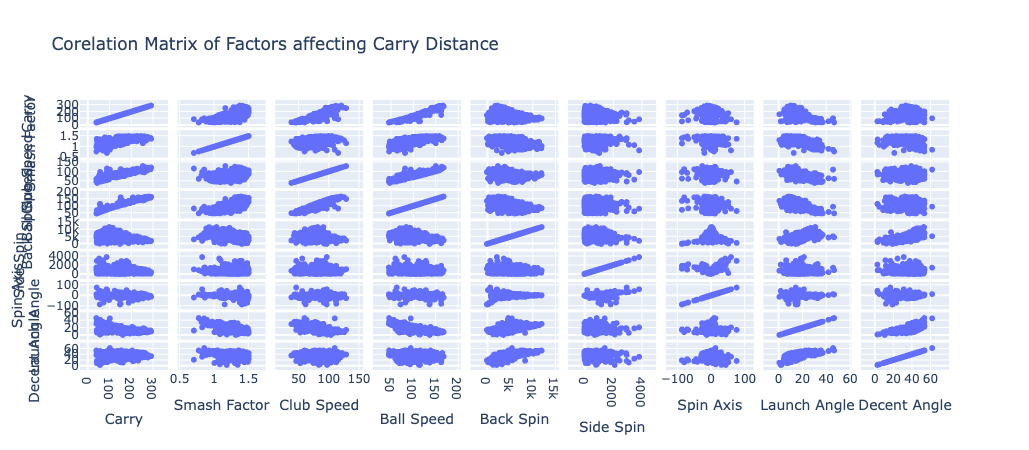

As we can see from the correlation matrix that smash factor, club speed and ball speed has positive impact of overall carry distance. Golfer trying to maximize distance should focus on these three factors. Factors such as back spin, side spin and spin axis has negative effect of carry distance. Interestingly launch angle has negative impact on carry distance whereas decent angle has positive impact on carry distance. 

In [18]:
carry_df.corr()

,Carry,Smash Factor,Club Speed,Ball Speed,Back Spin,Side Spin,Spin Axis,Launch Angle,Decent Angle
Carry,1.000000,0.659348,0.852952,0.967071,-0.409840,-0.088294,-0.027056,-0.598140,0.013321
Smash Factor,0.659348,1.000000,0.283978,0.687281,-0.422806,-0.024453,-0.100781,-0.622566,-0.181996
Club Speed,0.852952,0.283978,1.000000,0.885876,-0.310195,0.000295,0.022860,-0.556932,-0.033188
Ball Speed,0.967071,0.687281,0.885876,1.000000,-0.440651,-0.018554,-0.037529,-0.702241,-0.105615
Back Spin,-0.409840,-0.422806,-0.310195,-0.440651,1.000000,-0.146359,0.091689,0.566756,0.690802
Side Spin,-0.088294,-0.024453,0.000295,-0.018554,-0.146359,1.000000,0.215874,-0.006428,-0.132745
Spin Axis,-0.027056,-0.100781,0.022860,-0.037529,0.091689,0.215874,1.000000,0.038095,0.114095
Launch Angle,-0.598140,-0.622566,-0.556932,-0.702241,0.566756,-0.006428,0.038095,1.000000,0.662196
Decent Angle,0.013321,-0.181996,-0.033188,-0.105615,0.690802,-0.132745,0.114095,0.662196,1.000000


In [19]:
# Corr matrix of factors affecting carry distance

fig = px.scatter_matrix(carry_df,title='Corelation Matrix of Factors affecting Carry Distance')
#fig = px.scatter_matrix(vehicles_final[['price','age','cylinders','odometer']],title='Corelation Matrix of Factors affecting Carry Distance')
fig.show()

## Correlation Matrix -  Factors influencing shape of the trajectory

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Back Spin</th>
      <th>Side Spin Angle</th>
      <th>Side Spin</th>
      <th>Side Angle</th>
      <th>Type</th>
      <th>Face Angle</th>
      <th>Spin Axis</th>
      <th>Face Path Angle</th>
      <th>Club Path</th>
      <th>Club Path Angle</th>
      <th>Face to Path Angle</th>
      <th>Face to Path</th>
      <th>Side Dist Angle</th>
      <th>Side Angle Dir</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Back Spin</th>
      <td>1.000000</td>
      <td>0.135694</td>
      <td>-0.146359</td>
      <td>-0.318220</td>
      <td>0.058816</td>
      <td>-0.005018</td>
      <td>0.091689</td>
      <td>-0.260351</td>
      <td>-0.042966</td>
      <td>0.193724</td>
      <td>-0.075617</td>
      <td>-0.141284</td>
      <td>0.076895</td>
      <td>0.021092</td>
    </tr>
    <tr>
      <th>Side Spin Angle</th>
      <td>0.135694</td>
      <td>1.000000</td>
      <td>0.119259</td>
      <td>-0.018545</td>
      <td>0.236595</td>
      <td>0.160154</td>
      <td>0.612932</td>
      <td>-0.031319</td>
      <td>-0.008907</td>
      <td>-0.254063</td>
      <td>0.456053</td>
      <td>-0.106136</td>
      <td>0.635202</td>
      <td>0.111289</td>
    </tr>
    <tr>
      <th>Side Spin</th>
      <td>-0.146359</td>
      <td>0.119259</td>
      <td>1.000000</td>
      <td>0.301108</td>
      <td>-0.132307</td>
      <td>0.091373</td>
      <td>0.215874</td>
      <td>0.267330</td>
      <td>0.043857</td>
      <td>-0.170891</td>
      <td>0.256141</td>
      <td>0.321318</td>
      <td>0.193929</td>
      <td>0.096170</td>
    </tr>
    <tr>
      <th>Side Angle</th>
      <td>-0.318220</td>
      <td>-0.018545</td>
      <td>0.301108</td>
      <td>1.000000</td>
      <td>0.002269</td>
      <td>-0.053499</td>
      <td>0.014875</td>
      <td>0.819468</td>
      <td>0.108135</td>
      <td>-0.174028</td>
      <td>-0.002606</td>
      <td>0.425340</td>
      <td>-0.067776</td>
      <td>-0.035198</td>
    </tr>
    <tr>
      <th>Type</th>
      <td>0.058816</td>
      <td>0.236595</td>
      <td>-0.132307</td>
      <td>0.002269</td>
      <td>1.000000</td>
      <td>0.097875</td>
      <td>0.309128</td>
      <td>0.021846</td>
      <td>-0.061722</td>
      <td>-0.072716</td>
      <td>0.040565</td>
      <td>-0.033168</td>
      <td>0.210268</td>
      <td>0.073509</td>
    </tr>
    <tr>
      <th>Face Angle</th>
      <td>-0.005018</td>
      <td>0.160154</td>
      <td>0.091373</td>
      <td>-0.053499</td>
      <td>0.097875</td>
      <td>1.000000</td>
      <td>0.166260</td>
      <td>-0.014387</td>
      <td>0.141462</td>
      <td>0.241246</td>
      <td>0.282900</td>
      <td>0.065961</td>
      <td>0.474129</td>
      <td>0.845819</td>
    </tr>
    <tr>
      <th>Spin Axis</th>
      <td>0.091689</td>
      <td>0.612932</td>
      <td>0.215874</td>
      <td>0.014875</td>
      <td>0.309128</td>
      <td>0.166260</td>
      <td>1.000000</td>
      <td>0.026563</td>
      <td>-0.059629</td>
      <td>-0.227225</td>
      <td>0.368912</td>
      <td>-0.004360</td>
      <td>0.494966</td>
      <td>0.127584</td>
    </tr>
    <tr>
      <th>Face Path Angle</th>
      <td>-0.260351</td>
      <td>-0.031319</td>
      <td>0.267330</td>
      <td>0.819468</td>
      <td>0.021846</td>
      <td>-0.014387</td>
      <td>0.026563</td>
      <td>1.000000</td>
      <td>0.030230</td>
      <td>-0.103661</td>
      <td>0.030778</td>
      <td>0.637123</td>
      <td>-0.050851</td>
      <td>-0.037649</td>
    </tr>
    <tr>
      <th>Club Path</th>
      <td>-0.042966</td>
      <td>-0.008907</td>
      <td>0.043857</td>
      <td>0.108135</td>
      <td>-0.061722</td>
      <td>0.141462</td>
      <td>-0.059629</td>
      <td>0.030230</td>
      <td>1.000000</td>
      <td>-0.050792</td>
      <td>0.111366</td>
      <td>0.350134</td>
      <td>0.042453</td>
      <td>0.141578</td>
    </tr>
    <tr>
      <th>Club Path Angle</th>
      <td>0.193724</td>
      <td>-0.254063</td>
      <td>-0.170891</td>
      <td>-0.174028</td>
      <td>-0.072716</td>
      <td>0.241246</td>
      <td>-0.227225</td>
      <td>-0.103661</td>
      <td>-0.050792</td>
      <td>1.000000</td>
      <td>-0.460390</td>
      <td>0.013519</td>
      <td>-0.028243</td>
      <td>0.322086</td>
    </tr>
    <tr>
      <th>Face to Path Angle</th>
      <td>-0.075617</td>
      <td>0.456053</td>
      <td>0.256141</td>
      <td>-0.002606</td>
      <td>0.040565</td>
      <td>0.282900</td>
      <td>0.368912</td>
      <td>0.030778</td>
      <td>0.111366</td>
      <td>-0.460390</td>
      <td>1.000000</td>
      <td>0.063300</td>
      <td>0.420271</td>
      <td>0.175280</td>
    </tr>
    <tr>
      <th>Face to Path</th>
      <td>-0.141284</td>
      <td>-0.106136</td>
      <td>0.321318</td>
      <td>0.425340</td>
      <td>-0.033168</td>
      <td>0.065961</td>
      <td>-0.004360</td>
      <td>0.637123</td>
      <td>0.350134</td>
      <td>0.013519</td>
      <td>0.063300</td>
      <td>1.000000</td>
      <td>-0.038888</td>
      <td>0.039826</td>
    </tr>
    <tr>
      <th>Side Dist Angle</th>
      <td>0.076895</td>
      <td>0.635202</td>
      <td>0.193929</td>
      <td>-0.067776</td>
      <td>0.210268</td>
      <td>0.474129</td>
      <td>0.494966</td>
      <td>-0.050851</td>
      <td>0.042453</td>
      <td>-0.028243</td>
      <td>0.420271</td>
      <td>-0.038888</td>
      <td>1.000000</td>
      <td>0.462731</td>
    </tr>
    <tr>
      <th>Side Angle Dir</th>
      <td>0.021092</td>
      <td>0.111289</td>
      <td>0.096170</td>
      <td>-0.035198</td>
      <td>0.073509</td>
      <td>0.845819</td>
      <td>0.127584</td>
      <td>-0.037649</td>
      <td>0.141578</td>
      <td>0.322086</td>
      <td>0.175280</td>
      <td>0.039826</td>
      <td>0.462731</td>
      <td>1.000000</td>
    </tr>
  </tbody>
</table>
</div>

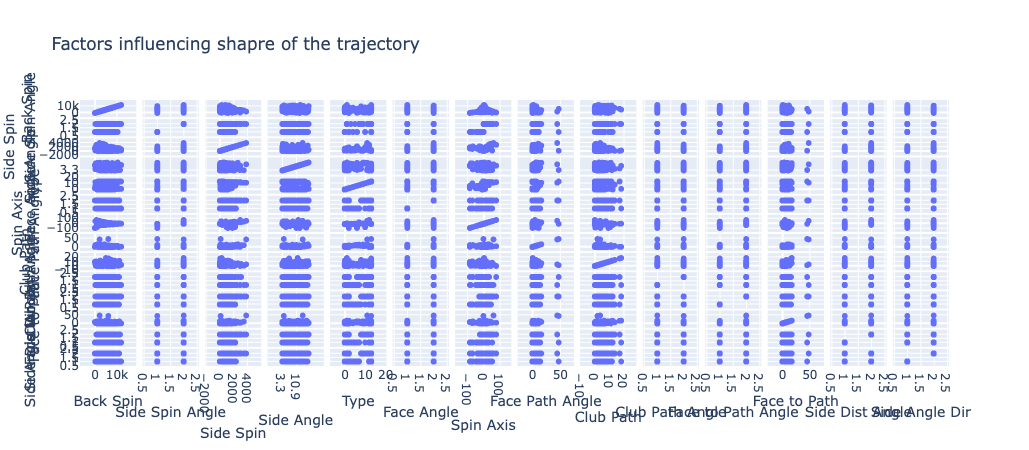

Side spin, spin axis and side spin angle has maximum positive corr with how shots forms its trajectory. Interestingly club path , face to path and side spin have negative correlation with shape of the trajectory. 

In [20]:
type_df.corr()

,Back Spin,Side Spin Angle,Side Spin,Side Angle,Type,Face Angle,Spin Axis,Face Path Angle,Club Path,Club Path Angle,Face to Path Angle,Face to Path,Side Dist Angle,Side Angle Dir
Back Spin,1.000000,0.135694,-0.146359,-0.318220,0.058816,-0.005018,0.091689,-0.260351,-0.042966,0.193724,-0.075617,-0.141284,0.076895,0.021092
Side Spin Angle,0.135694,1.000000,0.119259,-0.018545,0.236595,0.160154,0.612932,-0.031319,-0.008907,-0.254063,0.456053,-0.106136,0.635202,0.111289
Side Spin,-0.146359,0.119259,1.000000,0.301108,-0.132307,0.091373,0.215874,0.267330,0.043857,-0.170891,0.256141,0.321318,0.193929,0.096170
Side Angle,-0.318220,-0.018545,0.301108,1.000000,0.002269,-0.053499,0.014875,0.819468,0.108135,-0.174028,-0.002606,0.425340,-0.067776,-0.035198
Type,0.058816,0.236595,-0.132307,0.002269,1.000000,0.097875,0.309128,0.021846,-0.061722,-0.072716,0.040565,-0.033168,0.210268,0.073509
Face Angle,-0.005018,0.160154,0.091373,-0.053499,0.097875,1.000000,0.166260,-0.014387,0.141462,0.241246,0.282900,0.065961,0.474129,0.845819
Spin Axis,0.091689,0.612932,0.215874,0.014875,0.309128,0.166260,1.000000,0.026563,-0.059629,-0.227225,0.368912,-0.004360,0.494966,0.127584
Face Path Angle,-0.260351,-0.031319,0.267330,0.819468,0.021846,-0.014387,0.026563,1.000000,0.030230,-0.103661,0.030778,0.637123,-0.050851,-0.037649
Club Path,-0.042966,-0.008907,0.043857,0.108135,-0.061722,0.141462,-0.059629,0.030230,1.000000,-0.050792,0.111366,0.350134,0.042453,0.141578
Club Path Angle,0.193724,-0.254063,-0.170891,-0.174028,-0.072716,0.241246,-0.227225,-0.103661,-0.050792,1.000000,-0.460390,0.013519,-0.028243,0.322086


In [21]:
# engine attributes correlation matrix
fig = px.scatter_matrix(type_df,title='Factors influencing shapre of the trajectory')
fig.show()



# Reduce dimensionality of this dataset using PCA method



## PCA of Carry attributes

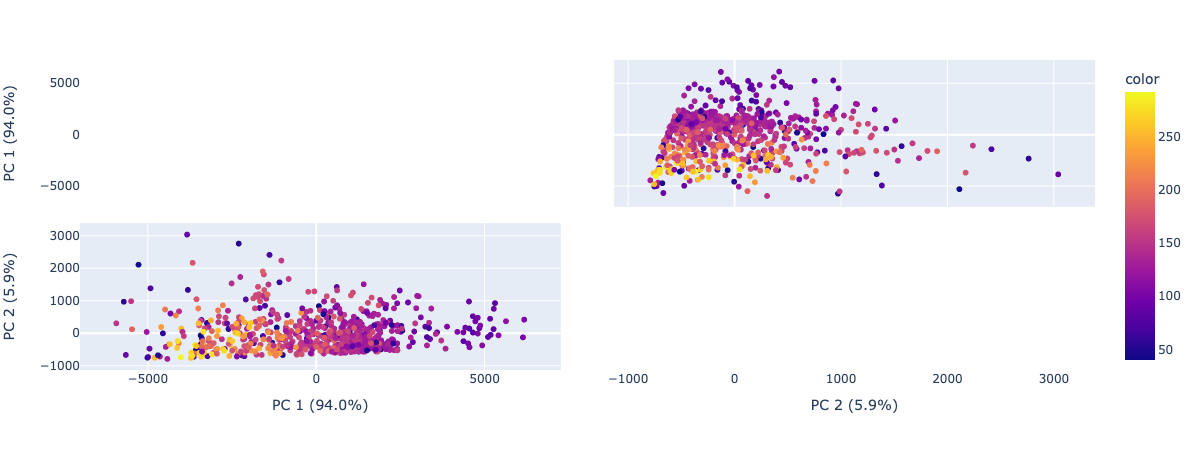

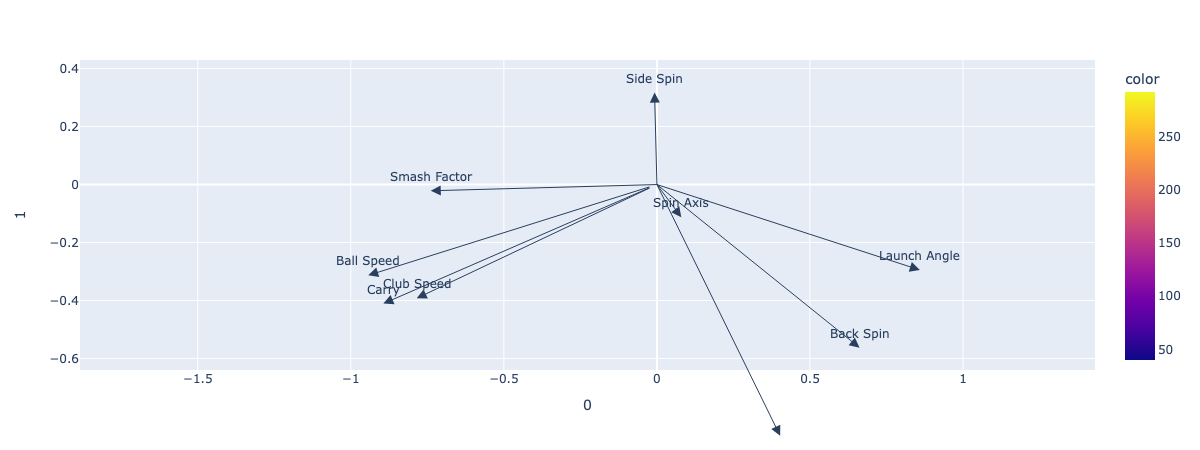

In [40]:

features = ['Carry','Smash Factor','Club Speed','Ball Speed','Back Spin','Side Spin','Spin Axis','Launch Angle','Decent Angle']
carry_pca= plot_pca(carry_df,features,'Carry')


[[-8.97184627e-03 -2.64584572e-05 -1.97371910e-03 -4.75070404e-03
   9.99153487e-01 -3.96776178e-02  5.41092522e-04  1.75515782e-03
   2.76817522e-03]
 [-1.35590041e-02 -2.29967387e-05 -1.25966895e-03 -3.84336524e-03
   3.95293294e-02  9.99101856e-01  5.61070121e-03  1.03073332e-03
  -4.06632890e-04]
 [-8.74025942e-01 -1.43238060e-03 -2.33272020e-01 -4.18293247e-01
  -1.07724124e-02 -1.33418941e-02 -1.38859565e-02  5.75584305e-02
  -5.37743555e-02]
 [-7.74549887e-04  8.87593583e-04 -2.27513003e-02  5.19965465e-02
   1.08849822e-03  5.70696821e-03 -9.97453396e-01 -4.88872141e-03
  -4.25019937e-02]
 [-3.08757316e-01 -1.62578884e-03  4.68961499e-01  3.94373035e-01
   2.29554421e-03 -2.14962323e-03  3.66662112e-02 -4.47710631e-01
  -5.72199430e-01]
 [-1.67259174e-01 -1.35630007e-02  8.12473839e-01 -9.49469390e-02
  -2.12957678e-03 -1.55683346e-03 -4.12807839e-02  4.01351263e-01
   3.74055951e-01]
 [-3.34884898e-01  1.34134813e-02 -2.34738412e-01  7.86788671e-01
  -1.24810631e-03 -1.8433756

In [41]:
# Print PCA Loadings
plot_pca_loading(carry_pca,carry_df,'Carry')

[[-0.89368124 -0.41037277]
 [-0.73884293 -0.02146384]
 [-0.78485988 -0.3921121 ]
 [-0.94314318 -0.31304207]
 [ 0.66203024 -0.56232959]
 [-0.0076695   0.31718214]
 [ 0.07959306 -0.11252848]
 [ 0.85890138 -0.29446062]
 [ 0.40277435 -0.86653098]]


## Carry Attributes reduction using Biplot 

|            |       PC1 |      PC2 |
|------------|-----------|----------|
Carry        |-0.436347 |-0.315888|
Smash Factor |-0.360746 |-0.016522|
Club Speed   |-0.383214| -0.301832|
Ball Speed   |-0.460498 |-0.240967|
Back Spin    | 0.323242 |-0.432859|
Side Spin    |-0.003745 | 0.244154|
Spin Axis    | 0.038862 |-0.086620|
Launch Angle  |0.419366 |-0.226664|
Decent Angle  |0.196658 |-0.667021|

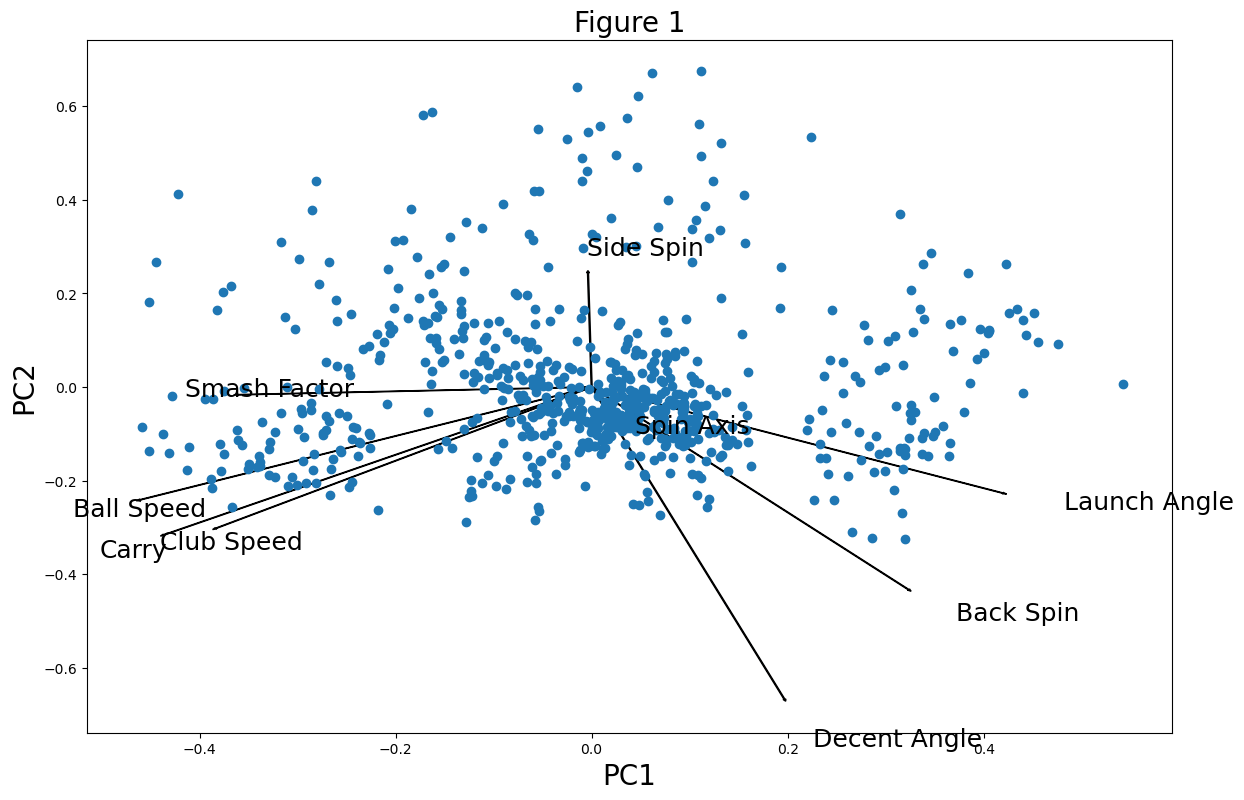

                   PC1       PC2
Carry        -0.436347 -0.315888
Smash Factor -0.360746 -0.016522
Club Speed   -0.383214 -0.301832
Ball Speed   -0.460498 -0.240967
Back Spin     0.323242 -0.432859
Side Spin    -0.003745  0.244154
Spin Axis     0.038862 -0.086620
Launch Angle  0.419366 -0.226664
Decent Angle  0.196658 -0.667021


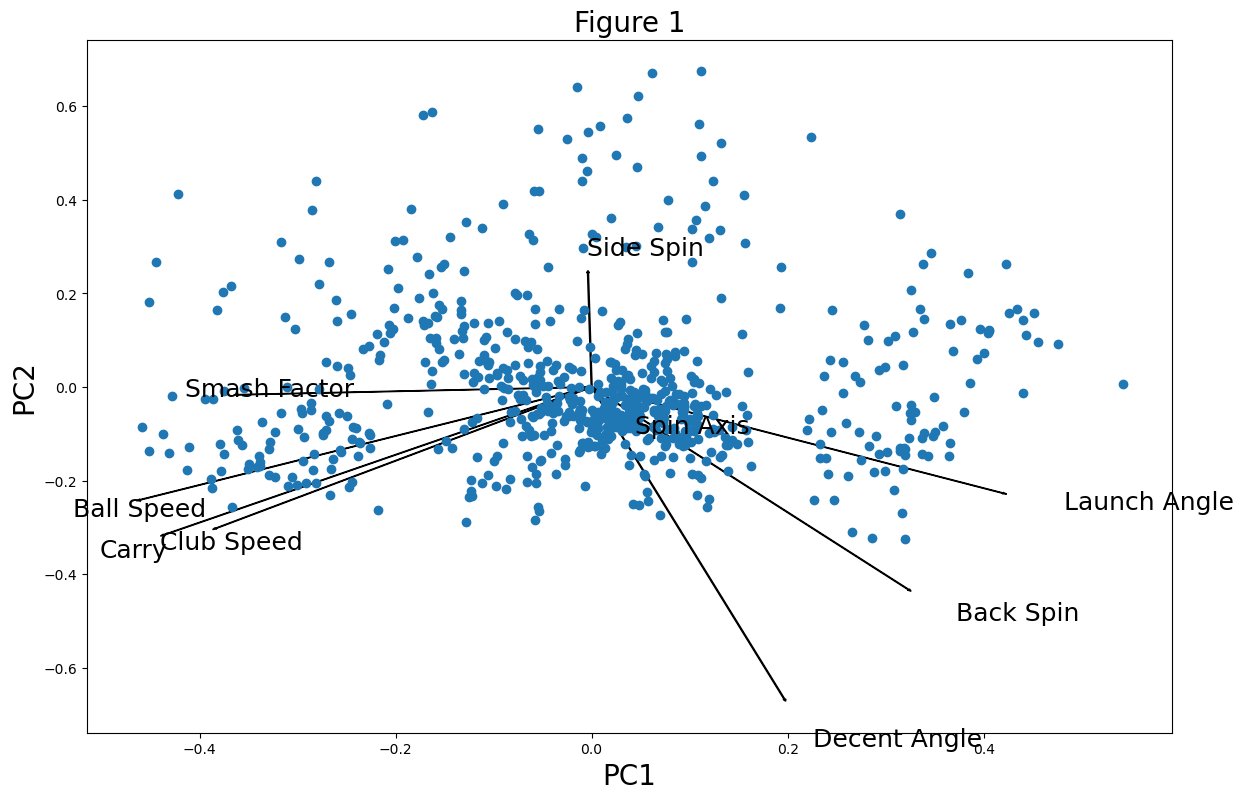

In [36]:
# PCA   Step 1: Scaled dataset
plot_biplot(carry_df)

## PCA of shape of trajectary data attributes

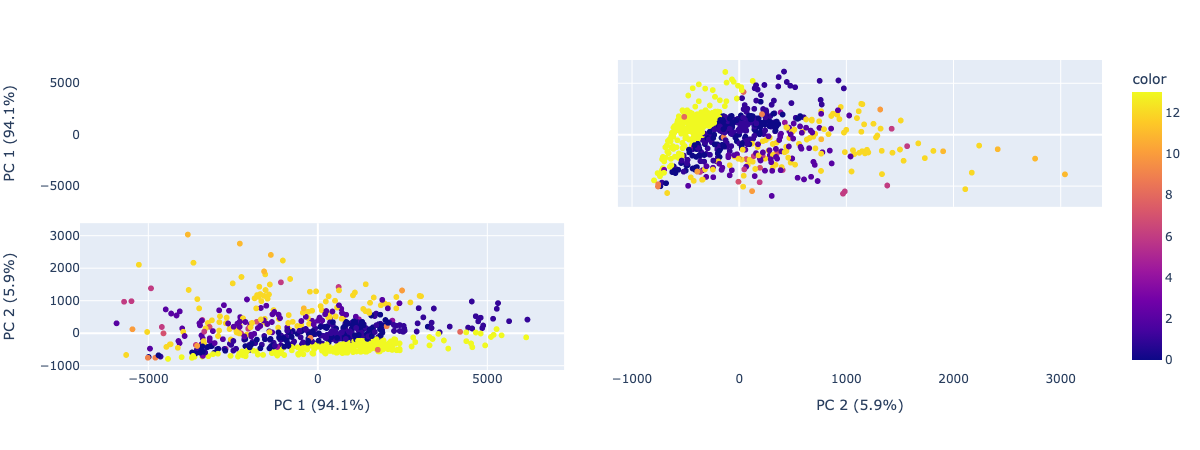


|                  |       PC1     |  PC2|
|------------------|---------------|-----|
Back Spin       |    0.011439| -0.284711|
Side Spin Angle  |   0.413378| -0.087277|
Side Spin       |    0.199156 | 0.286111|
Side Angle      |    0.040970 | 0.512493|
Type            |    0.171317|-0.072542|
Face Angle       |   0.346412| -0.090865|
Spin Axis         |  0.392884 |-0.032781|
Face Path Angle  |   0.050470 | 0.528567|
Club Path       |    0.073904 | 0.143316|
Club Path Angle  |  -0.119292 |-0.172804|
Face to Path Angle | 0.376864 | 0.051810|
Face to Path    |    0.058795|  0.442987|
Side Dist Angle |    0.466244| -0.113300|
Side Angle Dir |     0.314374| -0.103335|

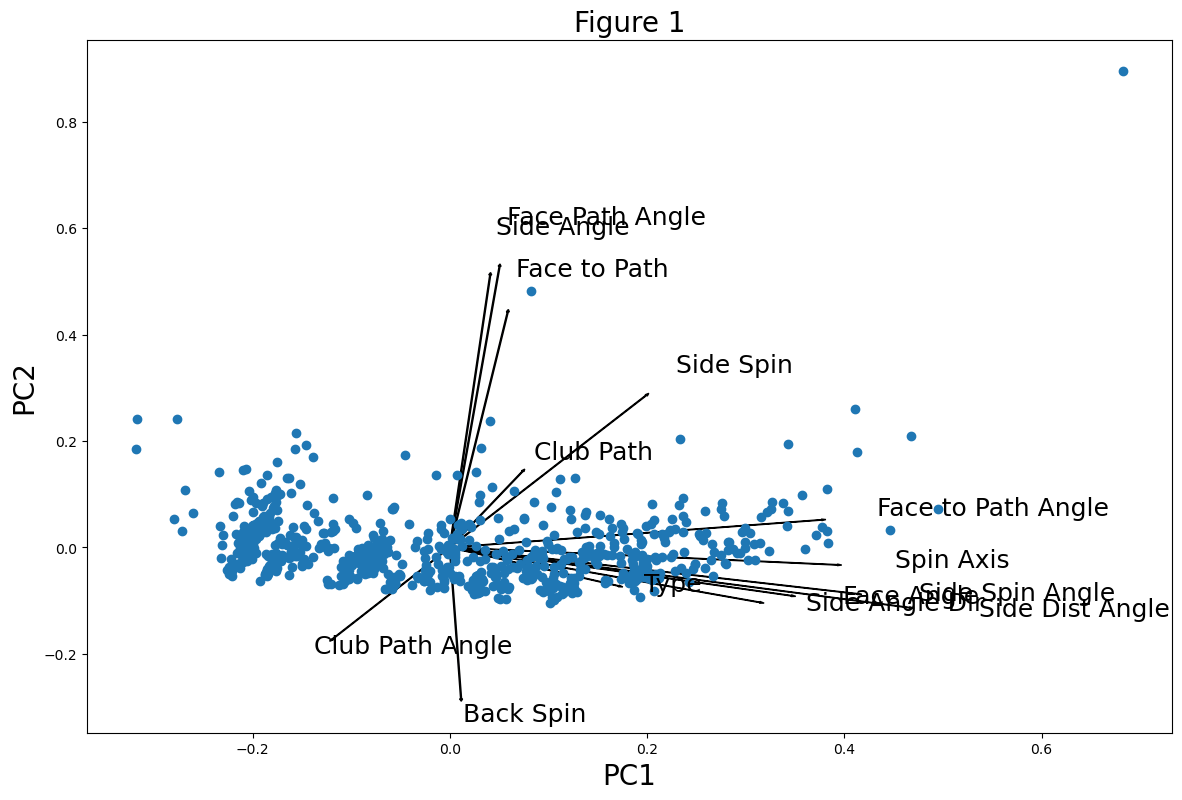

[[ 9.99211707e-01  3.10097616e-05 -3.96896139e-02 -3.87009176e-04
   1.62454225e-04 -1.35247072e-06  5.41133897e-04 -4.03448776e-04
  -4.74398477e-05  4.51216574e-05 -1.75603303e-05 -2.47092838e-04
   1.72613521e-05  4.56699251e-06]
 [ 3.96875496e-02  1.30612145e-04  9.99191539e-01  1.22082108e-03
  -1.33997826e-03  8.31647065e-05  5.61263887e-03  1.40140559e-03
   1.63620894e-04 -1.30892594e-04  2.21192082e-04  2.06234081e-03
   1.91268581e-04  9.10147240e-05]
 [ 7.75284021e-04 -2.28600965e-02  5.19212741e-03  2.73731355e-03
  -1.89118074e-01 -5.92611534e-03 -9.81087893e-01  2.87049171e-04
   1.34488641e-02  8.56591216e-03 -1.22778855e-02  1.91731415e-02
  -1.78309022e-02 -4.18560773e-03]
 [ 1.27283602e-04 -7.69835516e-04  1.79602917e-03  8.46768987e-02
   9.63977866e-01  4.33869695e-03 -1.83287987e-01  1.29826541e-01
   1.19355859e-03 -9.57703444e-04 -6.48287076e-03  1.14194766e-01
   2.72993251e-03  3.48634726e-03]
 [ 4.31774223e-04 -6.81368028e-03 -3.24185630e-03  3.72368091e-01
  

                         PC1       PC2
Back Spin           0.011439 -0.284711
Side Spin Angle     0.413378 -0.087277
Side Spin           0.199156  0.286111
Side Angle          0.040970  0.512493
Type                0.171317 -0.072542
Face Angle          0.346412 -0.090865
Spin Axis           0.392884 -0.032781
Face Path Angle     0.050470  0.528567
Club Path           0.073904  0.143316
Club Path Angle    -0.119292 -0.172804
Face to Path Angle  0.376864  0.051810
Face to Path        0.058795  0.442987
Side Dist Angle     0.466244 -0.113300
Side Angle Dir      0.314374 -0.103335


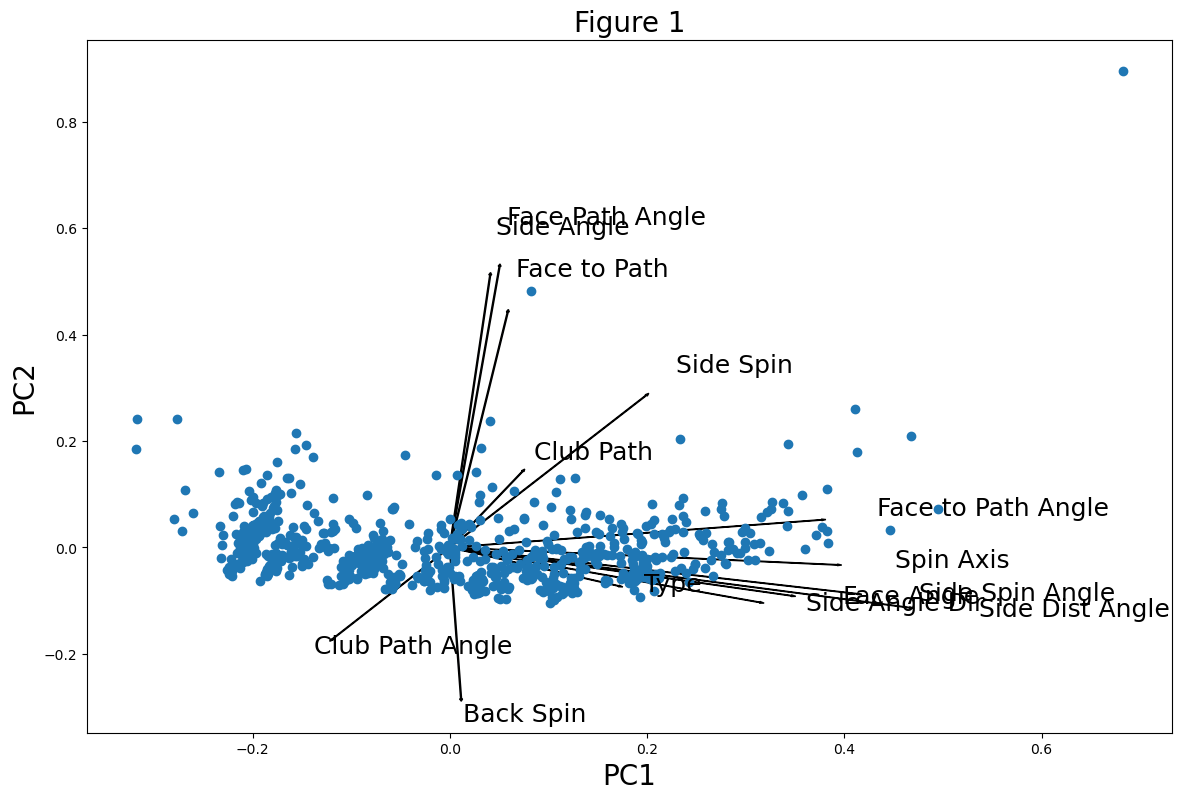

In [43]:
features = ['Back Spin','Side Spin Angle','Side Spin','Side Angle','Type','Face Angle','Spin Axis','Face Path Angle','Club Path','Club Path Angle','Face to Path Angle','Face to Path','Side Dist Angle','Side Angle Dir']
type_pca= plot_pca(type_df,features,'Type')
plot_biplot(type_df)


# KMean Analysis

## Kmean - Carry dataset

In [46]:
scaler = StandardScaler()
scaler.fit(carry_df) 
carry_scaled = scaler.transform(carry_df)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(carry_scaled)
kmeans.inertia_

# KMean intertia is 4752.913814366739. Now, let’s see how we can use the elbow method to determine the optimum number of clusters in Python.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



4752.913814366739

## Kmean clustering of Carry dataset using Elbow method

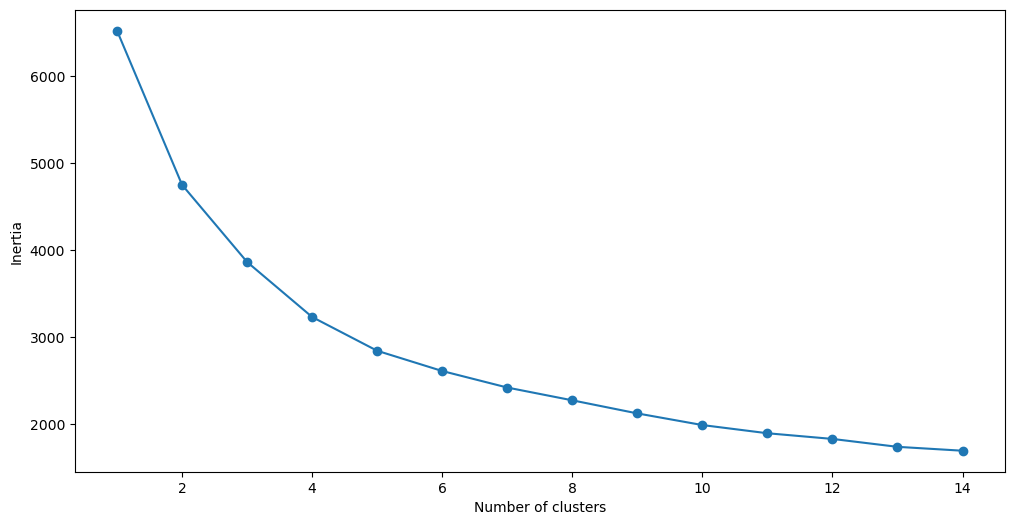

Optimal cluster value is 6. Which means 875 golf swings can be clustered in 8 clusters.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/hetalpate

Text(0, 0.5, 'Inertia')

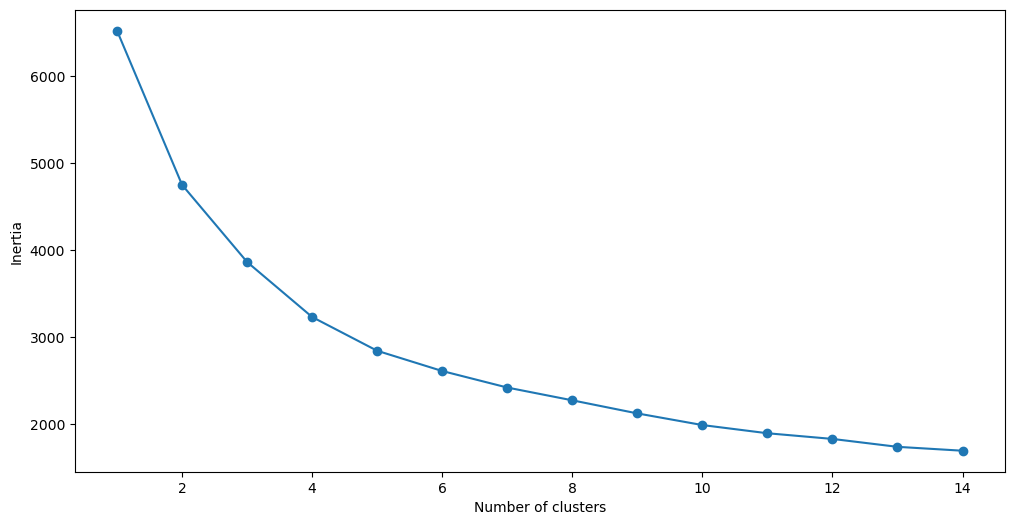

In [49]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,15):
    kmeans = KMeans( n_clusters = cluster, init='k-means++')
    kmeans.fit(carry_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,15), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

## Kmean - Swing Type dataset

In [50]:
scaler = StandardScaler()
scaler.fit(type_df) 
type_scaled = scaler.transform(type_df)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(type_scaled)
kmeans.inertia_

#  # KMean intertia is 8429.79165777031. Now, let’s see how we can use the elbow method to determine the optimum number of clusters in Python.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



8429.79165777031

## Kmean clustering of Swing Type dataset using Elbow method

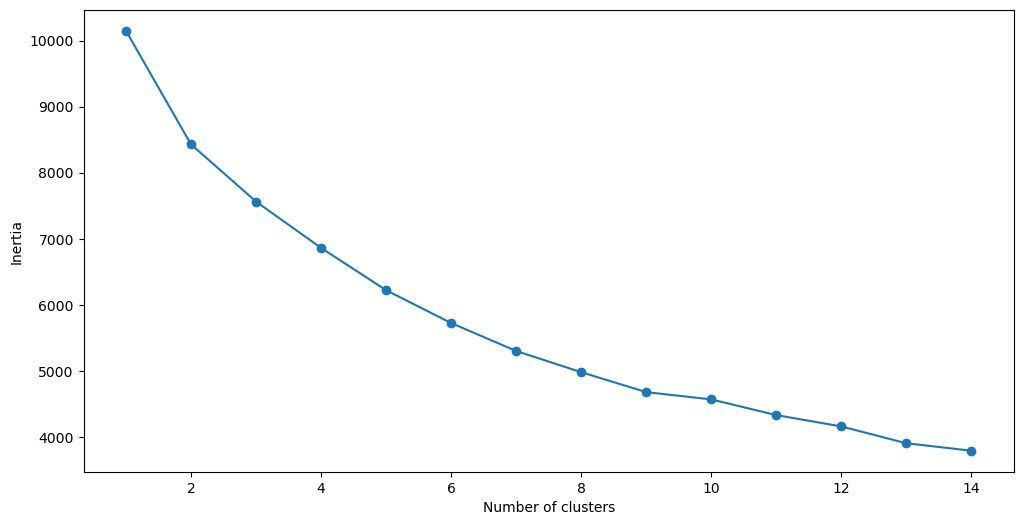

Optimal cluster value is 8. Which means 875 golf swings can be clustered in 8 clusters.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/hetalpate

Text(0, 0.5, 'Inertia')

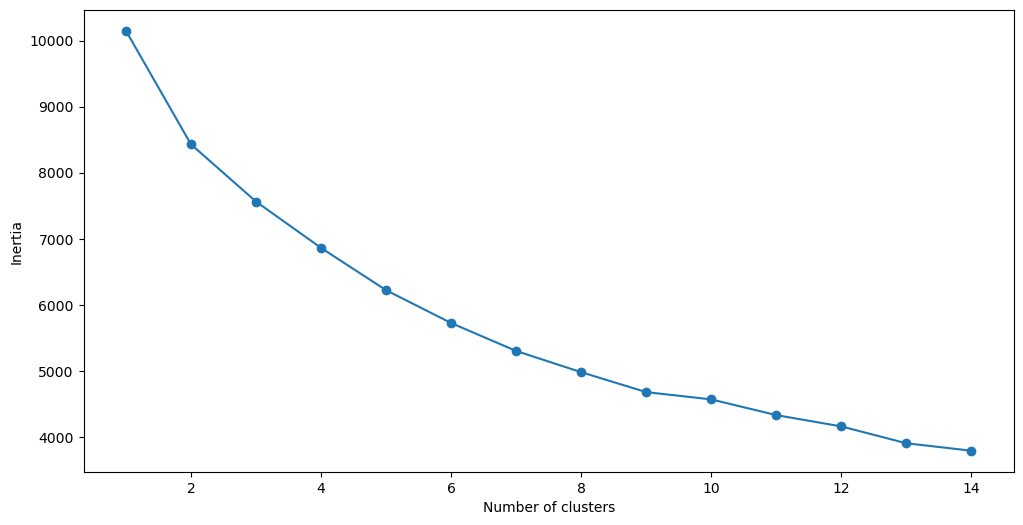

In [51]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,15):
    kmeans = KMeans( n_clusters = cluster, init='k-means++')
    kmeans.fit(type_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,15), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Model Development - Predict shape of ball trajectory 

In [63]:
type_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 725 entries, 2 to 875
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Back Spin           725 non-null    float64
 1   Side Spin Angle     725 non-null    int64  
 2   Side Spin           725 non-null    float64
 3   Side Angle          725 non-null    object 
 4   Type                725 non-null    int64  
 5   Face Angle          725 non-null    int64  
 6   Spin Axis           725 non-null    float64
 7   Face Path Angle     725 non-null    float64
 8   Club Path           725 non-null    float64
 9   Club Path Angle     725 non-null    int64  
 10  Face to Path Angle  725 non-null    int64  
 11  Face to Path        725 non-null    float64
 12  Side Dist Angle     725 non-null    int64  
 13  Side Angle Dir      725 non-null    int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 85.0+ KB


In [81]:
#  Separate Features and Lables

type_features = type_df.drop(columns=['Type'])  # all rows, all the features and no labels
type_lable = type_df['Type']  # all rows, label only
#X_features.head()
type_features.info()


sc = MinMaxScaler()
type_feature_scaled = sc.fit_transform(type_features)
#  create train and test data set

X_type_train, X_type_test, y_type_train, y_type_test = train_test_split(type_features,type_lable,test_size=0.2,random_state=4)

<class 'pandas.core.frame.DataFrame'>
Index: 725 entries, 2 to 875
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Back Spin           725 non-null    float64
 1   Side Spin Angle     725 non-null    int64  
 2   Side Spin           725 non-null    float64
 3   Side Angle          725 non-null    object 
 4   Face Angle          725 non-null    int64  
 5   Spin Axis           725 non-null    float64
 6   Face Path Angle     725 non-null    float64
 7   Club Path           725 non-null    float64
 8   Club Path Angle     725 non-null    int64  
 9   Face to Path Angle  725 non-null    int64  
 10  Face to Path        725 non-null    float64
 11  Side Dist Angle     725 non-null    int64  
 12  Side Angle Dir      725 non-null    int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 79.3+ KB


## Baseline Model Performance

Baseline model performance is 32.13%

In [70]:
#  create a baseline performance model which is bare minimum performance this modeling execise should achieve
dummy_clf = DummyClassifier(strategy='most_frequent',random_state=3)
dummy_clf.fit(type_feature_scaled, type_lable)
dummy_clf.predict(type_feature_scaled)
dummy_clf.score(type_feature_scaled, type_lable)

0.3213793103448276

## Logistic Regression

### Step 1 :  Base Model performance -  82.75%

In [85]:
model_LR= LogisticRegression(solver='liblinear',multi_class='ovr')
start = process_time()
model_LR.fit(X_type_train,y_type_train)
end = process_time()
train_time = end-start
y_pred = model_LR.predict(X_type_test)
train_accuracy = accuracy_score(y_type_test, y_pred)
print(" Logistic Regression accuracy=",train_accuracy)

 Logistic Regression accuracy= 0.8275862068965517


###  Step 2 : Confusion Matrix

Confusion Matrix
Confusion matrix helps to visualize the performance of the model
The diagonal elements represent the number of points for which the predicted label is equal to the true label
Off-diagonal elements are those that are mislabeled by the classifier.
The higher the diagonal values of the confusion matrix the better, indicating many correct

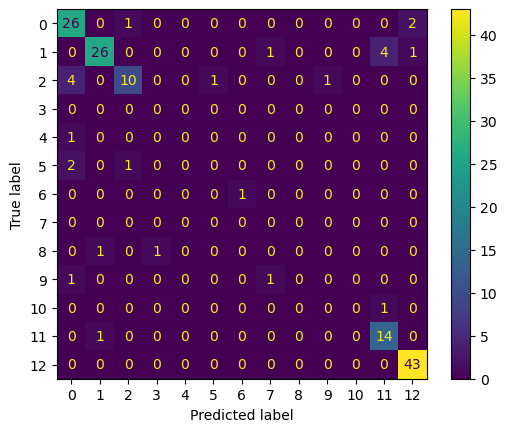

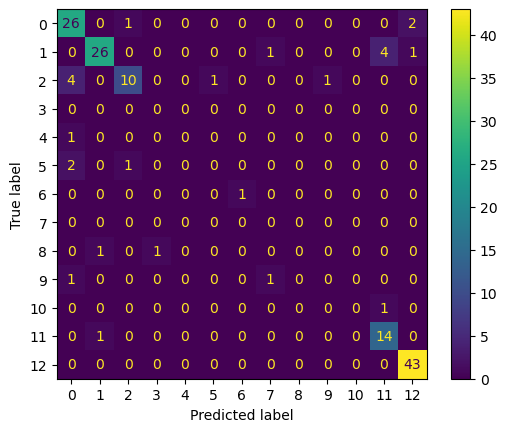

In [94]:
#Creating matplotlib axes object to assign figuresize and figure title
cm = confusion_matrix(y_type_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

### Step 3:  Classification Report

Classification Report
Classification report is used to measure the quality of prediction from classification algorithm

Precision: Indicates how many classes are correctly classified
Recall: Indicates what proportions of actual positives was identified correctly
F-Score: It is the harmonic mean between precision & recall
Support: It is the number of occurrence of the given class in our dataset

              precision    recall  f1-score   support

           0       0.76      0.90      0.83        29
           1       0.93      0.81      0.87        32
           2       0.83      0.62      0.71        16
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.74      0.93      0.82        15
          13       0.93      1.00      0.97        43

    accuracy                           0.83       145
   macro avg       0.40      0.41      0.40       145
weighted avg       0.81      0.83      0.81       145





In [88]:
print(metrics.classification_report(y_type_test, model_LR.predict(X_type_test)))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83        29
           1       0.93      0.81      0.87        32
           2       0.83      0.62      0.71        16
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.74      0.93      0.82        15
          13       0.93      1.00      0.97        43

    accuracy                           0.83       145
   macro avg       0.40      0.41      0.40       145
weighted avg       0.81      0.83      0.81       145



/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-

### Step 4: KFold Cross-validation and hyper parameter tuning

-   Average score(newton-cg): 0.710
-   Average score(lbfgs): 0.710
-   Average score(liblinear): 0.677
-   Average score(sag): 0.710
-   Average score(saga): 0.710

In [102]:
from numpy import mean
kf = KFold(n_splits=5, random_state=1, shuffle=True)
#scores = cross_val_score(model_LR, type_features, type_lable, scoring='accuracy', cv=cv, n_jobs=-1)
#test_accuracy= mean(scores)
#print("Test Accuracy",test_accuracy)


algorithms = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for algo in algorithms:
    score = cross_val_score(LogisticRegression(max_iter= 4000, solver= algo, random_state= 42), type_feature_scaled, type_lable, cv= kf, scoring="accuracy")
    print(f'Average score({algo}): {"{:.3f}".format(score.mean())}')

Average score(newton-cg): 0.710
Average score(lbfgs): 0.710
Average score(liblinear): 0.677
Average score(sag): 0.710
Average score(saga): 0.710


## KNN Classifier

### Step 1: Tune K -  Final results for Best K is 5.

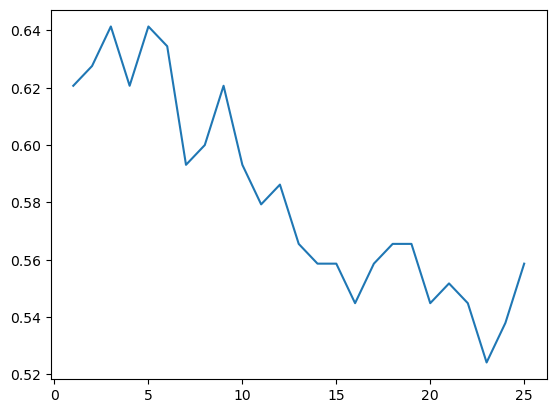

We will rerun the same K tuning for between 3 and 6.  

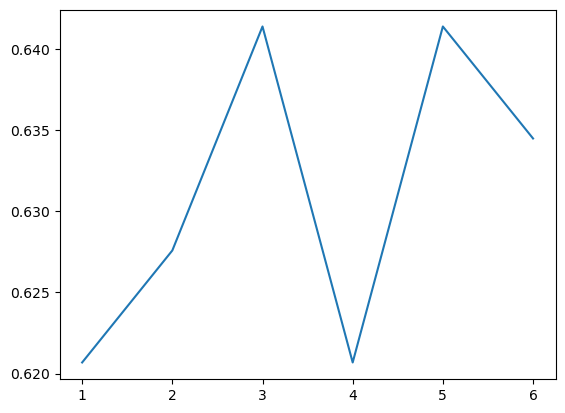

Best, K value is 3 and 5. We will use K=5 for remaining part of hypertuning.

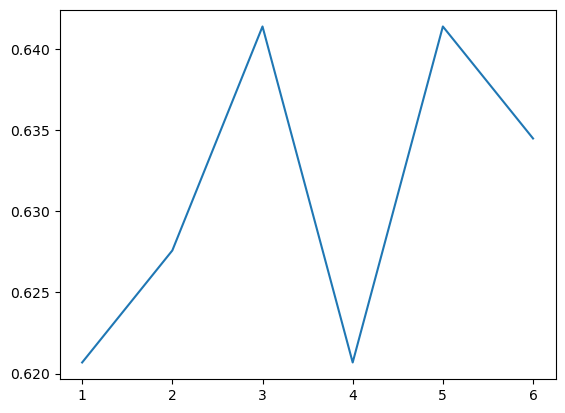

In [114]:
k_range = list(range(1,7))
scores = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_type_train, y_type_train)
    y_pred = knn.predict(X_type_test)
    scores.append(metrics.accuracy_score(y_type_test, y_pred))
plt.plot(k_range, scores)
plt.show()

### Step 2 :  Base K model performance with K_neighbours = 5

-   Knn Test Accuracy K_neighbours=1  is 64.97%

        -   Classification report for KNeighborsClassifier(n_neighbors=1):
                    precision    recall  f1-score   support

                0       0.50      0.48      0.49        29
                1       0.59      0.53      0.56        32
                2       0.60      0.56      0.58        16
                4       0.00      0.00      0.00         1
                5       0.00      0.00      0.00         0
                6       0.00      0.00      0.00         3
                7       0.00      0.00      0.00         1
                9       0.00      0.00      0.00         2
                10       0.00      0.00      0.00         2
                11       0.00      0.00      0.00         1
                12       0.40      0.53      0.46        15
                13       0.88      0.98      0.92        43

            accuracy                           0.62       145
        macro avg       0.25      0.26      0.25       145
        weighted avg       0.60      0.62      0.61       145

-   Knn Test Accuracy K=5 is 61.66%

In [119]:
knn_clf, knn_train_accuracy, train_time = calc_knn_acc(X_type_train,y_type_train,X_type_test,y_type_test,1)  # Accuracy when K=12

scores = cross_val_score(knn_clf, type_features, type_lable, scoring='accuracy', cv=cv, n_jobs=-1)
knn_test_accuracy= round(mean(scores)*100,2)
print("Knn Test Accuracy K=1 ",knn_test_accuracy)

knn_clf, knn_train_accuracy, train_time = calc_knn_acc(X_type_train,y_type_train,X_type_test,y_type_test,5 ) # Accuracy when K=12

scores = cross_val_score(knn_clf, type_features, type_lable, scoring='accuracy', cv=cv, n_jobs=-1)
knn_test_accuracy= round(mean(scores)*100,2)
print("Knn Test Accuracy K=5 ",knn_test_accuracy)

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-

Classification report for KNeighborsClassifier(n_neighbors=1):
              precision    recall  f1-score   support

           0       0.50      0.48      0.49        29
           1       0.59      0.53      0.56        32
           2       0.60      0.56      0.58        16
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.40      0.53      0.46        15
          13       0.88      0.98      0.92        43

    accuracy                           0.62       145
   macro avg       0.25      0.26      0.25       145
weighted avg       0.60      0.62      0.61       145

Knn Test Accuracy K=1  64.97
Classification report for KNeighborsClass

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Step 3 : Gridsearch CV of KNN Classifier

-   Hyperparameters
    -   Best leaf_size: 2
    -   Best p: 1
    -   Best n_neighbors: 1

-   best score - 67.93%

In [123]:
leaf_size = [2,3,4,5,6,7,8]
n_neighbors = [1,2,3,4,5,6,7,8]
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
start= process_time()
best_model = clf.fit(X_type_train,y_type_train)
end = process_time()
knn_train_time = end -start
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('best score',best_model.best_score_)



/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



Best leaf_size: 2
Best p: 1
Best n_neighbors: 1
best score 0.6793103448275863


### Step 4:  Confusion Matrix

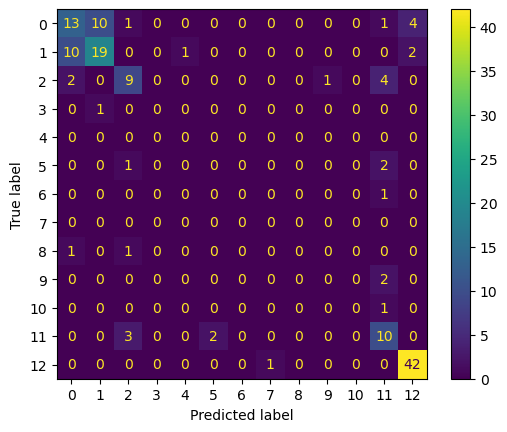

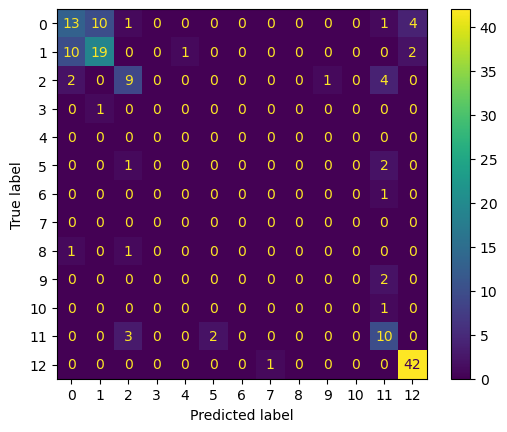

In [136]:
final_model = best_model.best_estimator_
Y_knn_pred = final_model.predict(X_type_test)

cm_knn = confusion_matrix(y_type_test, Y_knn_pred)

cm_knn_display = ConfusionMatrixDisplay(cm_knn).plot()

## SVM Model Performance

### Step 1: Base SVM model performance - 90%

Classification report for SVC(kernel='linear'):
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       1.00      0.94      0.97        32
           2       0.87      0.81      0.84        16
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           6       0.50      0.67      0.57         3
           7       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.81      0.87      0.84        15
          13       1.00      1.00      1.00        43

    accuracy                           0.90       145
   macro avg       0.51      0.52      0.51       145
weighted avg       0.89      0.90      0.89       145

SVM Test Accuracy 96%

In [126]:
svm_clf, svm_train_accuracy, train_time = calc_SVM_acc(X_type_train,y_type_train,X_type_test,y_type_test) 

scores = cross_val_score(svm_clf,type_features, type_lable, scoring='accuracy', cv=cv, n_jobs=-1)
svm_test_accuracy= round(mean(scores)*100,2)
print("SVM Test Accuracy",svm_test_accuracy)

Classification report for SVC(kernel='linear'):
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       1.00      0.94      0.97        32
           2       0.87      0.81      0.84        16
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           6       0.50      0.67      0.57         3
           7       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.81      0.87      0.84        15
          13       1.00      1.00      1.00        43

    accuracy                           0.90       145
   macro avg       0.51      0.52      0.51       145
weighted avg       0.89      0.90      0.89       145



/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-

SVM Test Accuracy 9600.0


### Step 2:  SVM Hyperparameter tuning


-   Best Accuracy - 0.9517241379310345
-   Best C: 1 
-   Best Kernel: linear 
-   Best Gamma: 1 

In [130]:
tuned_parameters = {
 #'C': [1, 10, 100,500, 1000], 'kernel': ['linear','rbf'],
 'C': [1, 10, 100], 'gamma': [1,0.1,0.01], 'kernel': ['rbf','linear'],
 #'degree': [2,3,4,5,6] , 'C':[1,10,100,500,1000] , 'kernel':['poly']
    }

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

svm_model= SVC()

model_svm = GridSearchCV(svm_model, tuned_parameters,refit = True)

model_svm.fit(X_type_train, y_type_train)
print(model_svm.best_score_)
print('Best C:',model_svm.best_estimator_.C,"\n") 
print('Best Kernel:',model_svm.best_estimator_.kernel,"\n")
print('Best Gamma:',model_svm.best_estimator_.gamma,"\n")

/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



0.9517241379310345
Best C: 1 

Best Kernel: linear 

Best Gamma: 1 



### Step 3: Confusion Matrix

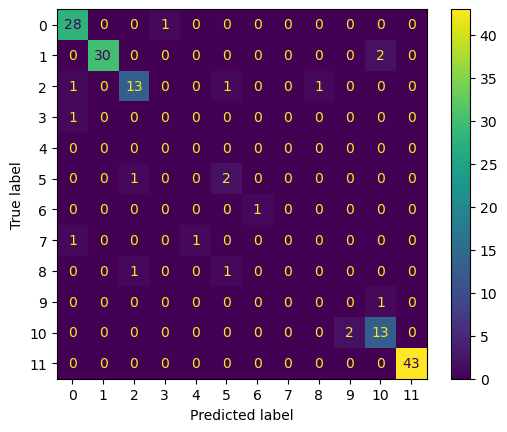

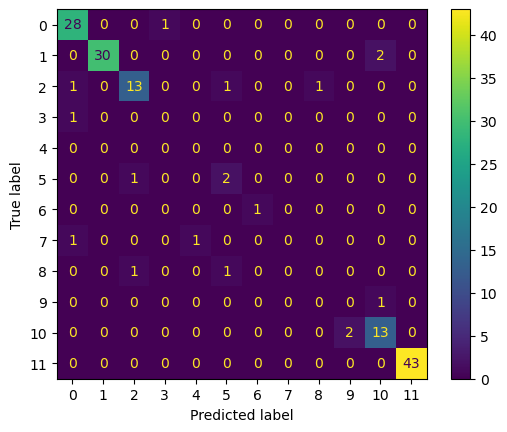

In [135]:
final_model = model_svm.best_estimator_
Y_svm_pred = final_model.predict(X_type_test)

cm_svm = confusion_matrix(y_type_test, Y_svm_pred)

cm_svm_display = ConfusionMatrixDisplay(cm_svm).plot()


## DecisionTree Model Performance

###  Step 1:  DecisionTree base model performance - 98.62%

Classification report for DecisionTreeClassifier(criterion='entropy', random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.97      1.00      0.98        32
           2       1.00      1.00      1.00        16
           4       1.00      1.00      1.00         1
           6       0.75      1.00      0.86         3
           7       1.00      1.00      1.00         1
           9       1.00      0.50      0.67         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        43

    accuracy                           0.99       145
   macro avg       0.97      0.91      0.93       145
weighted avg       0.99      0.99      0.98       145

DecisionTree Accuracy= 98.62

In [145]:
ds_clf, ds_train_accuracy, train_time=calc_decision_acc(X_type_train,y_type_train,X_type_test,y_type_test)
print("DecisionTree Accuracy=",ds_train_accuracy)

Classification report for DecisionTreeClassifier(criterion='entropy', random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.97      1.00      0.98        32
           2       1.00      1.00      1.00        16
           4       1.00      1.00      1.00         1
           6       0.75      1.00      0.86         3
           7       1.00      1.00      1.00         1
           9       1.00      0.50      0.67         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        43

    accuracy                           0.99       145
   macro avg       0.97      0.91      0.93       145
weighted avg       0.99      0.99      0.98       145

DecisionTree Accuracy= 98.62


### Step 2:  DS hyperparameter tuning

-   Accuracy - 0.9758620689655172
-   Best C: DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=0) 

In [147]:
params_ds = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=ds_clf, 
                           param_grid=params_ds, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

ds_model = grid_search.fit(X_type_train, y_type_train)

print(ds_model.best_score_)
print('Best Estimator:',ds_model.best_estimator_,"\n") 


Fitting 4 folds for each of 50 candidates, totalling 200 fits


/Users/hetalpatel/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=4.



0.9758620689655172
Best C: DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=0) 



### Step 3:  Confusion Matrix

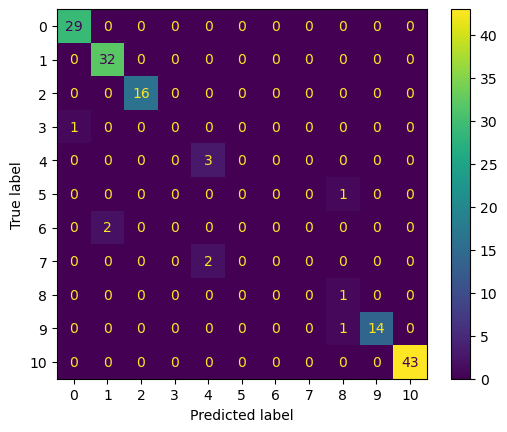

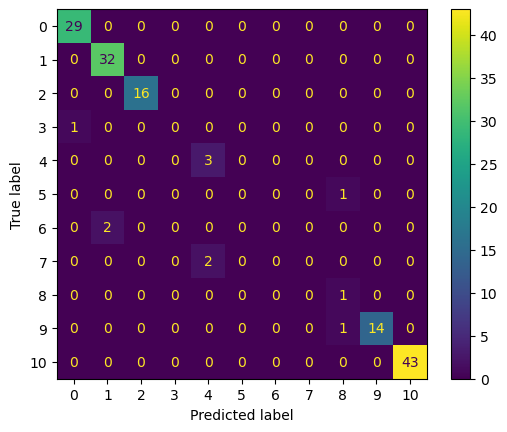

In [150]:
final_model = ds_model.best_estimator_
Y_ds_pred = final_model.predict(X_type_test)

cm_ds = confusion_matrix(y_type_test, Y_ds_pred)

cm_ds_display = ConfusionMatrixDisplay(cm_ds).plot()


## Model Comparison

| Model | Base model Performance | Performance of Tuned Model |
|-------|------------------------|----------------------------|
| LGR   |  82.75%                | 71% |
| KNN   |  64.97%               |  67.94% |
| SVM   |  96%                  |  95.14% |
| DS    |  98%                   | 97.58% |